In [ ]:
# Importing neccessary liberaries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
# !pip install folium
# !pip install imbalanced-learn
import folium
from imblearn.over_sampling import SMOTE
from scipy.stats import zscore
from sklearn import preprocessing
from sklearn.decomposition import PCA
from numpy.linalg import eigh
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn import multioutput
from sklearn.naive_bayes import GaussianNB
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Retreiving data from csv file
data= pd.read_csv('dkmacovid_train.csv')
df_train= data.copy()
df_test = pd.read_csv('dkmacovid_kaggletest_features.csv')

### Data Introduction and Explaination:

#### Fields Descriptions:
- Day: Date in January 2021 ranging from Jan 2 to Jan 31.
- State ID: Arbitrary ID number for each state, based on alphabetical order. Note there are 51 states since the District of Columbia is also included.
- State: Name of the US State.
- Lat: Latitude for the geographic centre of the state.
- Long_: Longitude for the geographic centre of the state.
- Active: Number of active, tracked COVID-19 cases that day in that state.
- Incident_Rate: Incidence Rate = cases per 100,000 persons.
- Total_Test_Results: Total number of people who have been tested.
- Case_Fatality_Ratio: Number recorded deaths * 100/ Number confirmed cases.
- Testing_Rate: Total test results per 100,000 persons. The "total test results" are equal to "Total test results (Positive + Negative)" from [COVID Tracking Project](https://covidtracking.com/).
- Resident Population 2020 Census: The number of population recorded in that State.
- Population Density 2020 Census: Population density is a measure of the average population per square mile of land.
- Density Rank 2020 Census: Density rankings 1 to 52 include the District of Columbia and Puerto Rico.
- SexRatio: the number of males per 100 females.
#### Label Description:
- Confirmed: Was there a daily increase in the confirmed total cases of COVID-19 in that state on that day?,if yes, then True else, False
- Deaths: Was there a daily increase in the number of deaths from COVID-19 in that state on that day?,if yes, then True else, False
- Recovered: Was there a daily increase in the number of people recovered from COVID-19 in that state on that day?,if yes, then True else, False

### Data Observation:
1) Through info(), the type od data, any null values and their count of row elements is visible. There are three Object data types .
2) Trhough nunique(), their count of unique row elements is visible and also , all the three boject datatypes has same nunique values.
3) Through describe() , invalid values and nature of data can checked.
4) Through isna(), null values can be rechecked.

In [ ]:
# checking for datatypes of each column and its count
df_train.info()

In [ ]:
# Checking for unique values
df_train.nunique()

In [ ]:
df_train.describe()

In [ ]:
# Checking for null values
df_train.isna().any()

### Visualization of areas effected by covid : 
The below map shows various areas affected by Covid , mentioned in training data and also, displays the features when clicked.

In [ ]:
# Training Data visualization throup folium maps
def data_plot(df):
    latest_record= df[df['Day']==max(df['Day'])]
    map_plot = folium.Map(location=[33,-102],tiles='Stamen Terrain',min_zoom=1, max_zoom=8,zoom_start=3.5)
    for i in range(0,len(latest_record)):
        tooltip=  ('<li><bold>State: ' + str(latest_record.iloc[i]['State']) 
                   + '<li><bold>Latitude:' + str(latest_record.iloc[i]['Lat'])
                   +'<li><bold>Longitude: ' + str(latest_record.iloc[i]['Long_']) 
                   +'<li><bold>Active: ' + str(latest_record.iloc[i]['Active'])
                   +'<li><bold>Incident_Rate: ' + str(latest_record.iloc[i]['Incident_Rate']) 
                   +'<li><bold>Total_Test_Results: ' + str(latest_record.iloc[i]['Total_Test_Results']) 
                   +'<li><bold>Case_Fatality_Ratio: ' + str(latest_record.iloc[i]['Case_Fatality_Ratio']) 
                   +'<li><bold>Testing_Rate: ' + str(latest_record.iloc[i]['Testing_Rate'])
                   +'<li><bold>Resident Population 2020 Census: '+ str(latest_record.iloc[i]['Resident Population 2020 Census'])
                   +'<li><bold>Population Density 2020 Census: ' + str(latest_record.iloc[i]['Population Density 2020 Census'])
                   +'<li><bold>Density Rank 2020 Census: ' + str(latest_record.iloc[i]['Density Rank 2020 Census']) 
                   +'<li><bold>SexRatio: ' + str(latest_record.iloc[i]['SexRatio'])
                   +'<li><bold>Confirmed: ' + str(latest_record.iloc[i]['Confirmed']) 
                   +'<li><bold>Deaths: ' + str(latest_record.iloc[i]['Deaths']) 
                   +'<li><bold>Recovered: ' + str(latest_record.iloc[i]['Recovered']))
        folium.Marker(location=[latest_record.iloc[i]['Lat'],latest_record.iloc[i]['Long_']],fill= 'red',
                  tooltip= tooltip,
                  radius= 50).add_to(map_plot)
        folium.CircleMarker(location=[latest_record.iloc[i]['Lat'],latest_record.iloc[i]['Long_']],color='red',fill= 'red',
                  tooltip= tooltip,
                  radius= 10).add_to(map_plot)
    return(map_plot)
# Training Data visualization throup folium maps
display('US States training data records of Covid ')
display(data_plot(data))

## CM[1]:
### Data Preprocessing:
1) Through data observation , it is clear that 'Population Density 2020 Census' and 'Resident Population 2020 Census'] is of object type having int type values with string format. So, we will convert them into their appropriate datatype for further analysis.

2) Then, as it is visible that 'State ID' represents the particular 'State' , so, the results can be achieved using one among these two columns. As, 'State' is object datatype ,so, it will be dropped to avoid further labelencoding , and , as 'State ID' is already a numerical value, so, it will be used.

3) Here, the 'Day' column can be treated in various ways:
   a) coversion into datetime timestamp: It can covert the values into datetime format but, in future steps it will make data preprocessing more complex while normalizing. So,It is discarded.
   b) One hot encoding: It can also be coverted into 0,1 format as , each integer here actually represents a particular time category. but, one hot encoding is encouraged in the case of object datatype , as the date categories in int format so, this method is also discarded.
   c) here, date starts from 2 till 31, which represents the change of 1 january to 2 january till 30 of jan to 31 jan.So, the int values here has meaning . So, it should be changed .Example, on day 2 , the congirmed cases are True , that means , the cases have increased compared to 1 january. 1st january here is base , on which the cases of next day is compared. Hence, it is already an integer value and it has special meaning with data. So, it should not be changed or removed.

In [ ]:
plt.plot(df_train['State ID'],df_train['State'])

In [8]:
# Function to convert string array to int
def str_int(column):
    list1=[]
    for i in column:
        list1.append(int(i.replace(',','')))
    return list1
# Function to convert string array to float
def str_float(column):
    list2=[]
    for j in column:
        list2.append(float(j.replace(',','')))
    return list2

# Function to return Preprocessed data
def preprocess(x):
    # Conversion of string into float
    if type(x['Population Density 2020 Census'][0]) == str:
        x['Population Density 2020 Census']= str_float(x['Population Density 2020 Census'])
    # conversion of string into int
    if type(x['Resident Population 2020 Census'][0]) == str:
        x['Resident Population 2020 Census']= str_int(x['Resident Population 2020 Census'])
    # Dropping 'State' column , as 'State ID' is already present
    if 'State' in x.columns:
        x.drop(['State'],axis=1,inplace=True)
    return x

In [9]:
# Preprocessed data
df_train = preprocess(df_train)

### Observation of Targets: 
### Checking Imbalanced Targets:
Here, there are three targets in this dataset, in which 'Confirmed' is extremely imbalanced , 'Death' column is also unbalanced whereas , 'Recovered' target is balanced fine. The below observation will show how greatly the individual targets are imbalanced . It also displays the need of resampling data.

In [10]:
df_Confirmed_1=df_train[df_train['Confirmed']==True]
df_Confirmed_0=df_train[df_train['Confirmed']==False]
df_Deaths_1=df_train[df_train['Deaths']==True]
df_Deaths_0=df_train[df_train['Deaths']==False]
df_Recovered_1=df_train[df_train['Recovered']==True]
df_Recovered_0=df_train[df_train['Recovered']==False]
print('The count of True cases in Confirmed target are {}'.format(df_Confirmed_1.shape[0]))
print('The count of False cases in Confirmed target are {}'.format(df_Confirmed_0.shape[0]))
print('The count of True cases in Deaths target are {}'.format(df_Deaths_1.shape[0] ))
print('The count of False cases in Deaths target are {}'.format(df_Deaths_0.shape[0] ))
print('The count of True cases in Recovered target are {}'.format(df_Recovered_1.shape[0] ))
print('The count of False cases in Recovered target are {}'.format(df_Recovered_0.shape[0] ))

### Outlier Detection:
The following graphs will represent the outliers in every feature. But, these outliers should not be removed as they belong to particular area( 'State ID' or 'State'). So, As this is a real time data , these outliers are actually displaying number based on particular state. for example, in 'Active' feature , the outlier belongs to 'State ID'= 5 i.e, California state. Similarly, We can see that in each graph all the outliers are of one colour meaning one State . So, these should not be replaced. If there is any valid outlier left, that will be taken care of in normalization part.

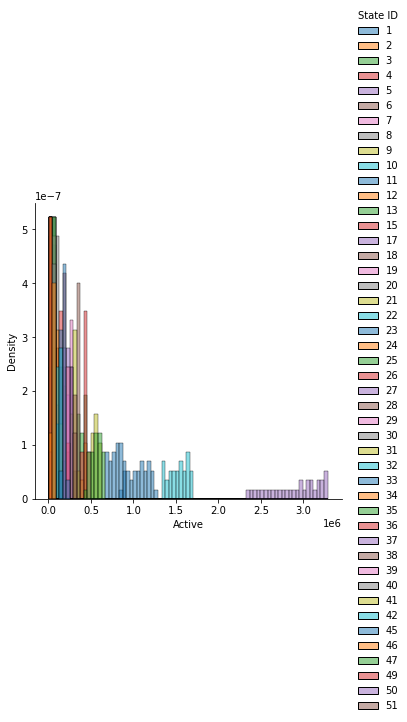

In [12]:
sns.displot(data=df_train, x='Active', stat='density',hue='State ID',palette=sns.color_palette(n_colors=46))

Below are the graphs of remaining features, here 'Residence population 2020 census' , 'Population densisty 2020 census' and 'sexRatio' show same lengths of bar plots because they, represent the measure of their kind in different states on aparticular day. As there are 46 states , so, is their unique count and any outlier in these graphs is the actual and valid value , varied among states. So, should not be mofified.

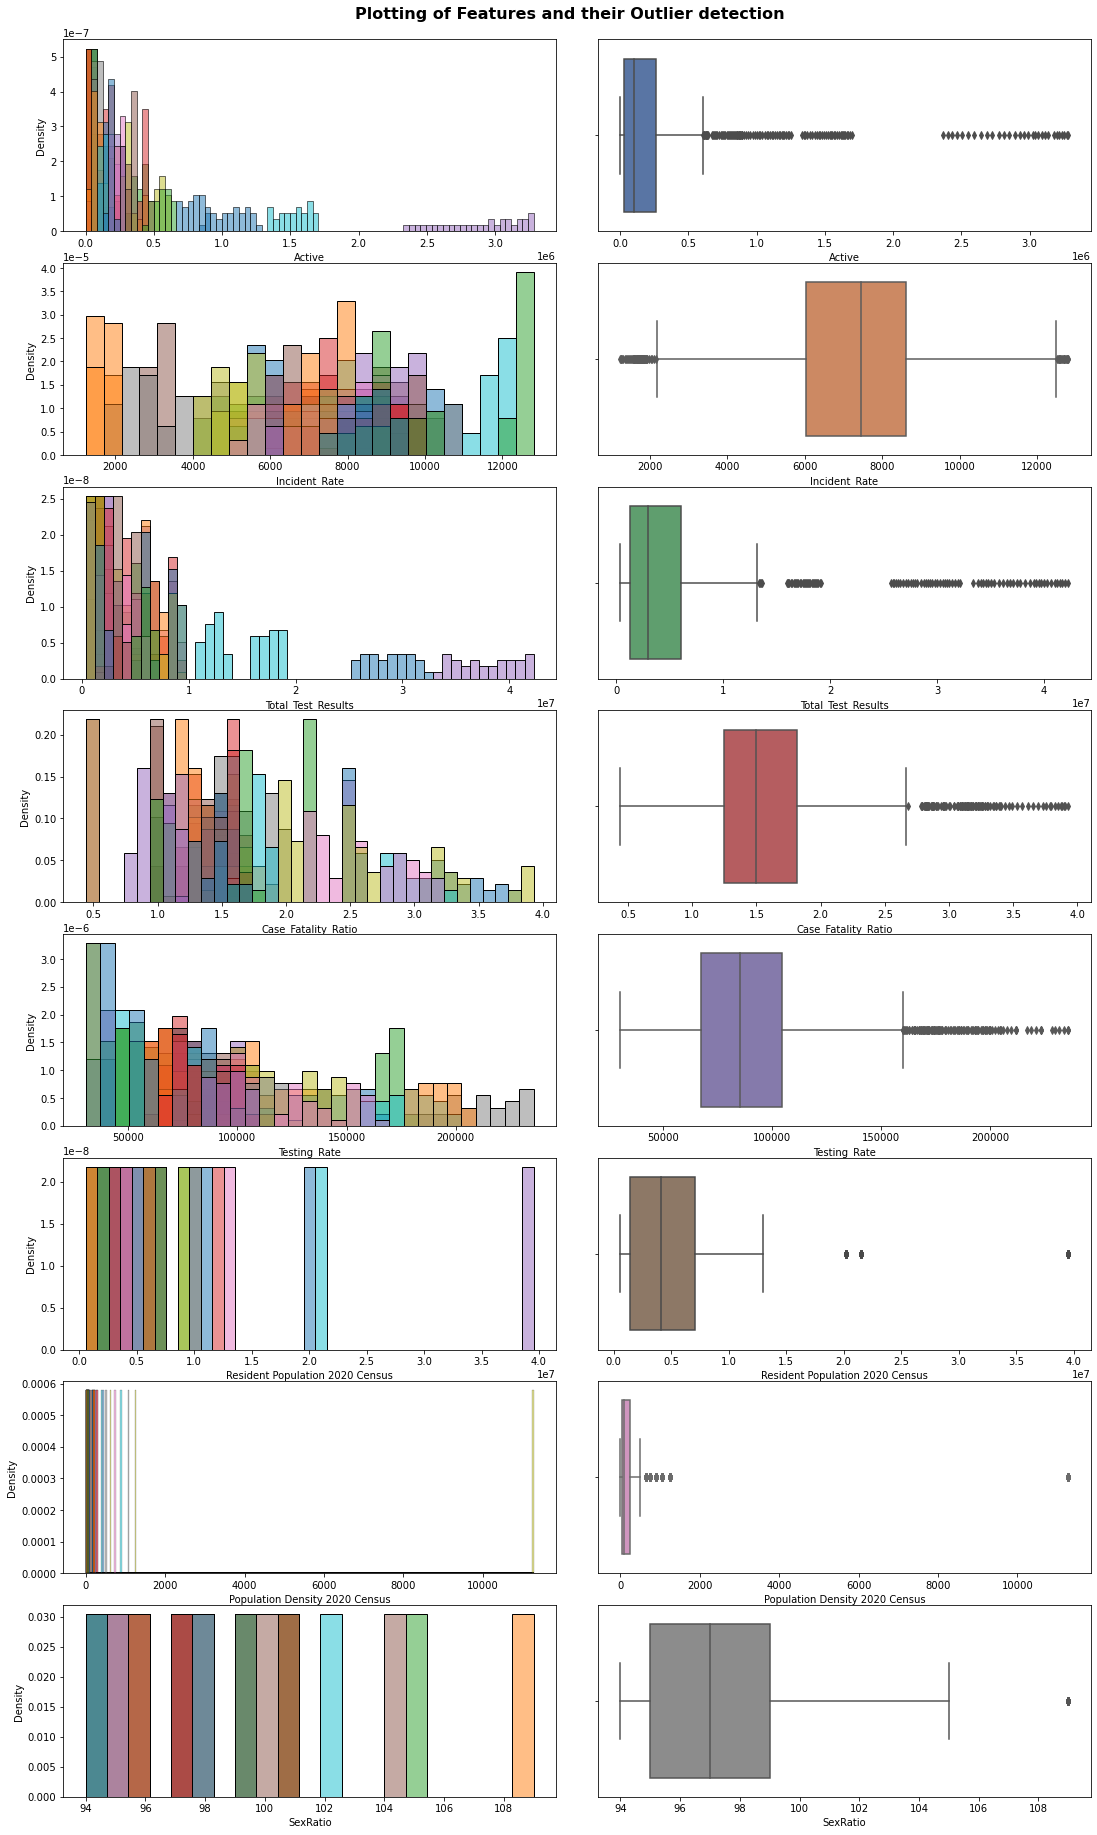

In [13]:
# Outliers detection
color=sns.color_palette('deep',8)
fig, axes= plt.subplots(8,2,figsize=(15,25))
fig.tight_layout()
sns.histplot(data=df_train,x='Active',hue='State ID',stat='density',palette=sns.color_palette(n_colors=46),legend=False,ax=axes[0,0])
sns.boxplot(df_train['Active'],color=color[0], ax=axes[0,1])
sns.histplot(data=df_train,x='Incident_Rate',hue='State ID',stat='density',palette=sns.color_palette(n_colors=46),legend=False,ax=axes[1,0])
sns.boxplot(df_train['Incident_Rate'],color=color[1], ax=axes[1,1])
sns.histplot(data=df_train,x='Total_Test_Results',hue='State ID',stat='density',palette=sns.color_palette(n_colors=46),legend=False,ax=axes[2,0])
sns.boxplot(df_train['Total_Test_Results'],color=color[2], ax=axes[2,1])
sns.histplot(data=df_train,x='Case_Fatality_Ratio',hue='State ID',stat='density',palette=sns.color_palette(n_colors=46),legend=False,ax=axes[3,0])
sns.boxplot(df_train['Case_Fatality_Ratio'],color=color[3], ax=axes[3,1])
sns.histplot(data=df_train,x='Testing_Rate',hue='State ID',stat='density',palette=sns.color_palette(n_colors=46),legend=False,ax=axes[4,0])
sns.boxplot(df_train['Testing_Rate'],color=color[4] ,ax=axes[4,1])
sns.histplot(data=df_train,x='Resident Population 2020 Census',hue='State ID',stat='density',palette=sns.color_palette(n_colors=46),legend=False,ax=axes[5,0])
sns.boxplot(df_train['Resident Population 2020 Census'],color=color[5], ax=axes[5,1])
sns.histplot(data=df_train,x='Population Density 2020 Census',hue='State ID',stat='density',palette=sns.color_palette(n_colors=46),legend=False,ax=axes[6,0])
sns.boxplot(df_train['Population Density 2020 Census'],color=color[6], ax=axes[6,1])
sns.histplot(data=df_train,x='SexRatio',hue='State ID',stat='density',palette=sns.color_palette(n_colors=46),legend=False,ax=axes[7,0])
sns.boxplot(df_train['SexRatio'],color=color[7], ax=axes[7,1])
plt.suptitle('Plotting of Features and their Outlier detection',fontsize=16,fontweight='bold',y=1.01)
plt.show()

### Train_Test_Split():
Here, data will be assigned proper x_train, x_test, y_train variables for further process.

In [14]:
# data splitting
x_train = df_train.iloc[:,:-3]
y_train = df_train.iloc[:,-3:]
x_test= df_test.iloc[:,1:]

### Label Encoding of Targets:
As, the targets are provided in Boolean format, so it will be converted into int  (0,1) format for future model fitting without any errors.

In [15]:
# Label encoding for binary to integer conversion
le= preprocessing.LabelEncoder()
y_train['Confirmed']=le.fit_transform(y_train['Confirmed'])
y_train['Deaths']=le.fit_transform(y_train['Deaths'])
y_train['Recovered']=le.fit_transform(y_train['Recovered'])

### SMOTE for imbalanced targets:
From, observation of targets , it was clear that 'Confirmed' and 'Death' column are greately imbalanced . So, they will be resampled for achieving individual target predictions and accuracies. Also,'Recovered' target is already balanced . so, we will leave it as it is.Furthermore, their values will be implemented as well for comparision in with and without SMOTE method.

In [16]:
smote= SMOTE(sampling_strategy='minority')
x_sm_Confirmed, y_sm_Confirmed = smote.fit_resample(x_train,y_train.iloc[:,0])
x_sm_Deaths, y_sm_Deaths = smote.fit_resample(x_train,y_train.iloc[:,1])
y_sm_Confirmed.value_counts() ,y_sm_Deaths.value_counts()

(0    1329
 1    1329
 Name: Confirmed, dtype: int64,
 0    1244
 1    1244
 Name: Deaths, dtype: int64)

### Normalization :
Normalizarion is used to normalize the data values into a particular range, so, that they provide minimum error and maximum accuracy. Here, we use , zscore normalization, as it automatically handles outliers and provided good results. Normalization will only be applied to x train data. Below, is the defined function to get normalized dataframe of particular data.

In [17]:
# Normalizing data using Zscore
def norm(df):
    zscore_norm= zscore(df)
    x_train = pd.DataFrame(zscore_norm, columns= df.columns)
    return(x_train)
x_Confirmed = norm(x_sm_Confirmed)
x_Deaths = norm(x_sm_Deaths)
x_Recovered = norm(x_train)
x_train = norm(x_train)

## CM[2]:
## PCA: 
- Principal component analysis is a dimension reduction technique which transforms correlated features into less count of uncorrelated one, which are known as principal components.
- It Compresses the size of data and keeps the only and most important components required for predictions.
- The first component is supposed to have largest variance , which will keep decreasing till last principal component.
- for every new added component , the inertia will increase in susbspace and new axis will face less inertia than original compunents(Optimal).
- Therefore, to choose optimal component , variance or inertia should be calculated as, as lower the components , lower is the variance. 95% explained variance is used to compute the optimal number of principle components . 
- Although to be sure , one can also the check the performance of number of principal components based on the accuracy they provide.

### Finding best number of components or features  to be reduced
### a) Based on training set accuracy

Accuracy rate of varying n_components of PCA: 


,0,1,2,3,4,5,6,7,8,9,10,11
accuracy,0.952896,0.949078,0.9575,0.957035,0.958151,0.958194,0.958378,0.958562,0.958562,0.958562,0.958562,0.958562
n_components,2.000000,3.000000,4.0000,5.000000,6.000000,7.000000,8.000000,9.000000,10.000000,11.000000,12.000000,13.000000


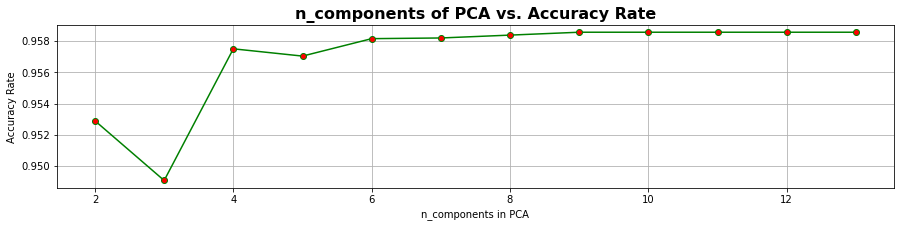

In [18]:
# Finding best number of components or features to be reduced w.r.t. accuracy of validation data
# Using KNN Classifier

from sklearn.neighbors import KNeighborsClassifier
scores=[]
for i in range(2,14):
    pca=PCA(n_components=i)
    pca.fit(x_train)
    x_pca= pca.transform(x_train)
    knn= KNeighborsClassifier()
    score= cross_val_score(knn,x_pca,y_train,cv=5, scoring='f1_macro')
    scores.append(score.mean())
plt.figure(figsize=(15,3))
plt.plot(np.arange(2,14),scores,marker='o',markerfacecolor='r',color='g')
plt.xlabel("n_components in PCA")
plt.ylabel("Accuracy Rate")
plt.title("n_components of PCA vs. Accuracy Rate", fontsize=16, fontweight='bold')
plt.grid()
scores= pd.DataFrame(scores, columns= ['accuracy'])
scores['n_components']= np.arange(2,14)
print('Accuracy rate of varying n_components of PCA: ')
display(scores.T)

### b) Based  on Explained_Variance_
95% of explained_variance_ is checked, whenever to tune the n_components parameter. Here, 95% of variance of data including all features is 12.35 . So, the first n_component providing a value higher than that will be treated as optimal component.

Total variance present in dataset is: 13.009427121102242
The required 95% variance is: 12.35895576504713
Explained Variance w.r.t. 1 PCA Components: 3.8797855315514016
Explained Variance w.r.t. 2 PCA Components: 6.336384954420247
Explained Variance w.r.t. 3 PCA Components: 7.962147802805228
Explained Variance w.r.t. 4 PCA Components: 9.225653953150195
Explained Variance w.r.t. 5 PCA Components: 10.333002535799716
Explained Variance w.r.t. 6 PCA Components: 11.084514399347617
Explained Variance w.r.t. 7 PCA Components: 11.718806068103712
Explained Variance w.r.t. 8 PCA Components: 12.182053175850275
Explained Variance w.r.t. 9 PCA Components: 12.61599536841635
Explained Variance w.r.t. 10 PCA Components: 12.816763993533403
Explained Variance w.r.t. 11 PCA Components: 12.925051803144658
Explained Variance w.r.t. 12 PCA Components: 12.99067317349015


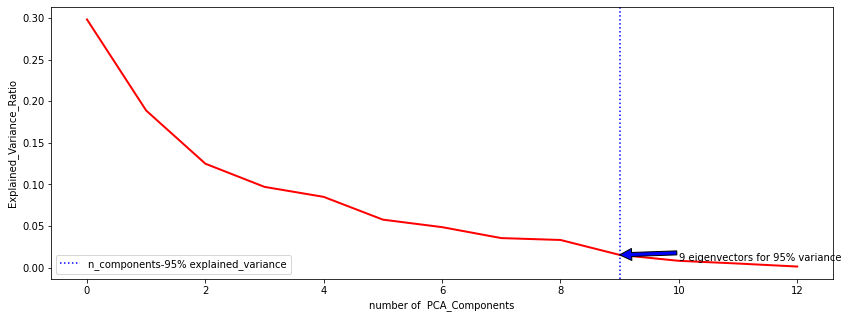

In [20]:
# first, the PCA of original datset will be calculated
num=x_train.shape[1]
pca=PCA(n_components=num)
x_pca= pca.fit(x_train).transform(x_train)
# calculation of original dataset variance
variance_sum=sum(pca.explained_variance_)
print('Total variance present in dataset is: {}'.format(variance_sum))
# Calculation of 95% variance
variance_95= variance_sum*0.95
print('The required 95% variance is: {}'.format(variance_95))

# Tuning the best n_components for PCA
pca_df= zip (range(0,num),pca.explained_variance_)
pca_df= pd.DataFrame(pca_df, columns=['PCA_Component','Explained_Variance'])
for i in range(1,num):
    print('Explained Variance w.r.t. {} PCA Components: {}'.format(i,sum(pca_df['Explained_Variance'][0:i])))

# Plotting graph of data
plt.figure(1,figsize=(14,5))
plt.plot(pca.explained_variance_ratio_,lw=2,c='r')
plt.xlabel("number of  PCA_Components")
plt.ylabel("Explained_Variance_Ratio")
# Plotting 95% explained_variance line
plt.axvline(9, linestyle=':',label='n_components-95% explained_variance',c='blue')
plt.legend()
# adding arrow to point the best found n_components
plt.annotate('9 eigenvectors for 95% variance',xy=(9,pca.explained_variance_ratio_[9]),
             xytext=(10,pca.explained_variance_ratio_[10]),arrowprops=dict(facecolor='blue'))
plt.show()

### Applying best found n_components:
 The best training data accuracy is found at number of components= 9 as well as, through explained_variance also, 9 turns out to be the best

In [21]:
# Function that returns PCA of given data and number of components
def pca(df,n):
    pca_=PCA(n_components=n)
    pca_1= pca_.fit(df).transform(df)
    return(pca_1)
# PCA dataframe with best found n_components
pca_best= pca(x_train,9)

### Scree Plot with  best Found parameter on PCA :
The below plot is showing that as the number of components increases their variance will decrease , although cumulative variance might increase. the first PCA component has large variance among all.

Text(0.5, 1.0, 'Scree Plot of variance explained ratio w.r.t. Principal Component values')

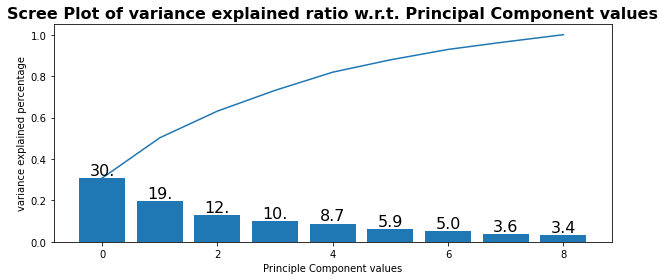

In [22]:
# to calculate explained variance ratio
egnvalues, egnvectors = eigh(np.cov(pca_best,rowvar=False))
explained_var_ratio=[]
for i in sorted(egnvalues, reverse=True):
    explained_var_ratio.append((i/sum(egnvalues)))

# values consisting of explained_variance_ratio_ of PCA and respective index
values = explained_var_ratio
index= np.arange(len(values))

# Plotting scree plot
plt.figure(figsize=(10,4))
cumulative_variance= np.cumsum(values)
plt.bar(index,values)
plt.plot(index,cumulative_variance)
for i in range(len(values)):
    plt.annotate(r'%s' % ((str(values[i]*100)[:3])),(index[i],values[i]), va='bottom',ha='center', fontsize=16)
plt.xlabel('Principle Component values')
plt.ylabel('variance explained percentage')
plt.title('Scree Plot of variance explained ratio w.r.t. Principal Component values',fontsize=16,fontweight='bold')

In [23]:
cumulative_variance

array([0.30752909, 0.5022501 , 0.63111531, 0.73126643, 0.81903982,
       0.878608  , 0.92888478, 0.96560381, 1.        ])

### Plotting of PCA1 and PCA2 data elemnets :
The below plot will display the first two principal components (important ones) and their distribution among different state feature.

Text(0.5, 1.0, 'Plot of Principal Component 1 and Principal Component 2')

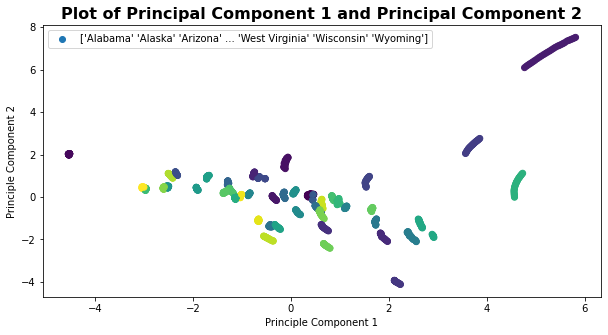

In [24]:
plt.figure(figsize=(10,5))
plt.scatter(pca_best[:,0],pca_best[:,1],c= x_train['State ID'],label=data['State'].values)
plt.xlabel('Principle Component 1')
plt.ylabel('Principle Component 2')
plt.legend(loc='best')
plt.title('Plot of Principal Component 1 and Principal Component 2',fontsize=16,fontweight='bold')

## CM[2]:
### LDA
Linear Discriminant Analysis is also dimensionality reduction technique. It is a supervised classification technique used in preprocessing and implemented for competitive machine learning models. 

Yes, LDA provides different performance results for different targets . For example, around 96% accuracy in 'Confirmed' target , 89% in 'Deaths' target and 77% in 'Recovered target . This is due to different balancing of targets. As, most of the targets of 'Confirmed' and 'Death' are True , and in case of 'Recovered' partial of the data is True and False.

#### LDA with 'Confirmed' Target output

The accuracy score for 'Confirmed' target by LDA: 0.9601449275362319


Text(0.5, 0.98, "LDA for 'Confirmed' Target")

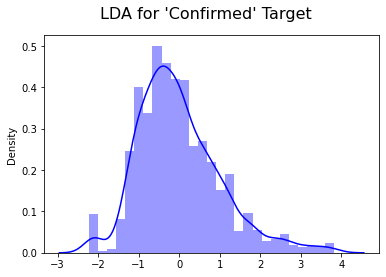

In [25]:
# Applying LDA on 'Confirmed' target
lda= LDA(n_components=1)
X1= lda.fit(x_train,y_train.iloc[:,0]).transform(x_train)
lda.fit(x_train,y_train.iloc[:,0])
lda_pred1=lda.predict(x_train)
lda_score1=accuracy_score(y_train.iloc[:,0],lda_pred1)
print("The accuracy score for 'Confirmed' target by LDA: {}".format(lda_score1))
sns.distplot(X1,color='blue')
plt.suptitle("LDA for 'Confirmed' Target", fontsize=16)

#### LDA with 'Deaths' Target output

The accuracy score for 'Deaths' target by LDA: 0.8905797101449275


Text(0.5, 0.98, "LDA for 'Deaths' Target")

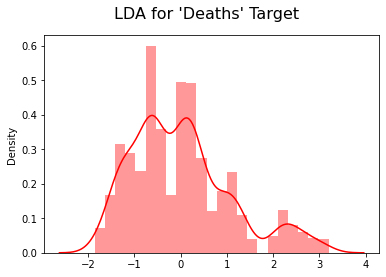

In [26]:
# Applying LDA on 'Deaths' target
X2= lda.fit(x_train,y_train.iloc[:,1]).transform(x_train)
lda.fit(x_train,y_train.iloc[:,1])
lda_pred2=lda.predict(x_train)
lda_score2=accuracy_score(y_train.iloc[:,1],lda_pred2)
print("The accuracy score for 'Deaths' target by LDA: {}".format(lda_score2))
sns.distplot(X2,color='red')
plt.suptitle("LDA for 'Deaths' Target", fontsize=16)

#### LDA with 'Recovered' Target output

The accuracy score for 'Recovered' target by LDA: 0.7746376811594203


Text(0.5, 0.98, "LDA for 'Recovered' Target")

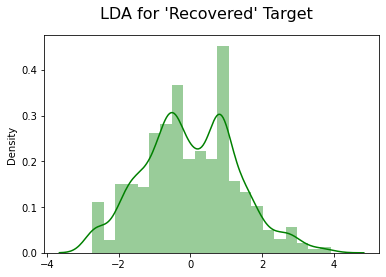

In [27]:
# Applying LDA on 'Recovered' target
X3= lda.fit(x_train,y_train.iloc[:,2]).transform(x_train)
lda.fit(x_train,y_train.iloc[:,2])
lda_pred3=lda.predict(x_train)
lda_score3=accuracy_score(y_train.iloc[:,2],lda_pred3)
print("The accuracy score for 'Recovered' target by LDA: {}".format(lda_score3))
sns.distplot(X3,color='green')
plt.suptitle("LDA for 'Recovered' Target", fontsize=16)

Here, LDA with 'Confirmed' target shows maximum accuracy on training data and 'Recovered' target gave minimum accuracy among all.

## Hyperparameter tuning with K-Fold Cross Validation:
This is used for further all parts.

In [28]:
# Hyperparameter tuning with K-Fold Crossvalidation, using GridSearchCV()
def hyperparameter_tuning(model,params,train,test):
    clf=GridSearchCV(model,params,cv=5,return_train_score=False)
    clf.fit(train,test)
    df=pd.DataFrame(clf.cv_results_)
    return df

## CM[3]:
### Decision Tree Classifier:

1) With Validation:
   - Without SMOTE
   
   a) Best max_depth for Combined targets is 5
   
   b) Best max_depth for 'Confirmed' targets is 3
   
   c) Best max_depth for 'Deaths' target is 3
   
   d) Best max_depth for 'Recovered' target is 10
   
   - With SMOTE
   
   a) Best max_depth for 'Confirmed' targets is 3
   
   b) Best max_depth for 'Deaths' target is 5
   
2) Without Validation:
   - Without SMOTE
   
   a) Best max_depth for Combined targets is None
   
   b) Best max_depth for 'Confirmed' targets is None
   
   c) Best max_depth for 'Deaths' target is None
   
   d) Best max_depth for 'Recovered' target is None
   
   - With SMOTE
   
   a) Best max_depth for 'Confirmed' targets is None
   
   b) Best max_depth for 'Deaths' target is None
   
3) The splitting rules , also known as criterion parameter is defined as gini and entropy. Among which gini provided slightly better results than entropy on some different max_depths. So, as the targets are imbalanced , thus, gini and entropy handles it fine,but not really good. Here, gini impurity lies in between 0 to 0.5 , whereas as entropy impurity lies in between 0 to 1. Thus, gini performs better for best feature selection.
 
So, max_depth here treats every target differently. Thus, their combination may provide better results.

### Hyper Parameter tuning of  max_depth(With K-fold Cross Validation):

In [29]:
def dtc_With_Validation(x,y,str1):
    # initiating DecisionTreeClassifier() and setting hyperparameters
    dtc=DecisionTreeClassifier()
    parameters1={'max_depth':[3,5,10,None]}

    # Decision Tree Classifier using 5-fold cross validation on original data
    dtc_df=hyperparameter_tuning(dtc,parameters1,x,y)
    dtc_df=dtc_df[['param_max_depth','mean_test_score']]

    # Plotting graph of Max Depth vs. Accuracy Rate
    plt.figure(figsize=(15,3))
    plt.plot(dtc_df['param_max_depth'],dtc_df['mean_test_score'],marker='o',markerfacecolor='r',color='g')
    plt.xlabel("Max Depth")
    plt.ylabel("Mean Accuracy Rate")
    plt.title("Max Depth vs. Mean Accuracy Rate ({})".format(str1), fontsize=16, fontweight='bold')
    plt.grid()

    # Printing exact values
    print("Accuracies w.r.t. varying Max depth, using original features({})".format(str1))
    display(dtc_df)

### Without SMOTE:

Accuracies w.r.t. varying Max depth, using original features(Combined)


,param_max_depth,mean_test_score
0,3,0.746377
1,5,0.818116
2,10,0.800000
3,None,0.799275


Accuracies w.r.t. varying Max depth, using original features(Confirmed)


,param_max_depth,mean_test_score
0,3,0.811594
1,5,0.809420
2,10,0.802899
3,None,0.800725


Accuracies w.r.t. varying Max depth, using original features(Deaths)


,param_max_depth,mean_test_score
0,3,0.900725
1,5,0.893478
2,10,0.883333
3,None,0.868841


Accuracies w.r.t. varying Max depth, using original features(Recovered)


,param_max_depth,mean_test_score
0,3,0.826812
1,5,0.897101
2,10,0.926087
3,None,0.915217


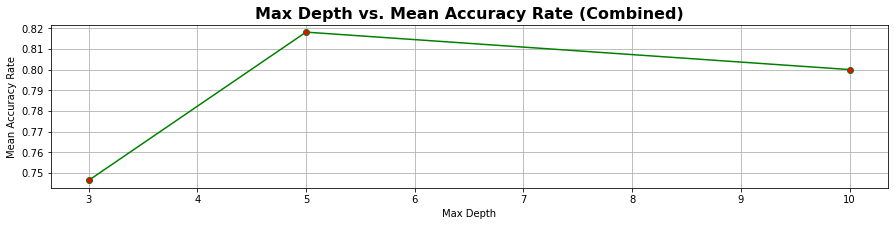

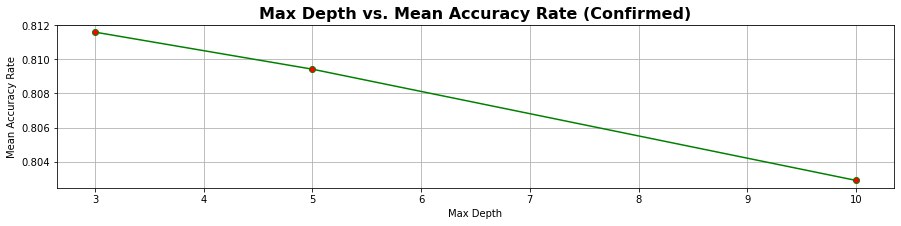

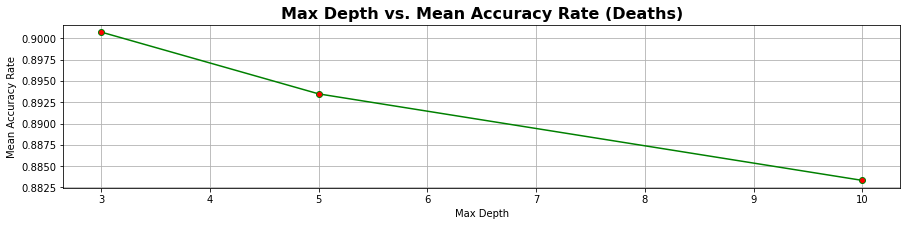

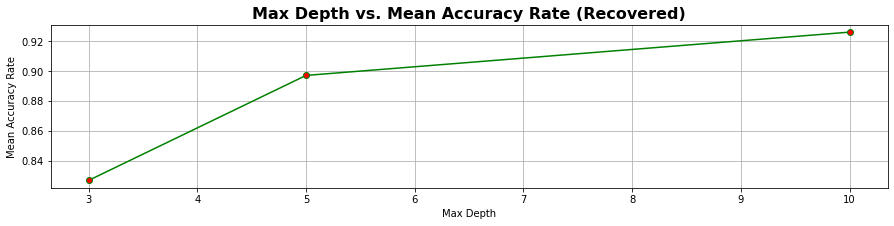

In [30]:
dtc_With_Validation_Combined= dtc_With_Validation(x_train,y_train,'Combined')
dtc_With_Validation_Confirmed= dtc_With_Validation(x_train,y_train['Confirmed'],'Confirmed')
dtc_With_Validation_Deaths= dtc_With_Validation(x_train,y_train['Deaths'],'Deaths')
dtc_With_Validation_Recovered= dtc_With_Validation(x_train,y_train['Recovered'],'Recovered')

### With SMOTE:

Accuracies w.r.t. varying Max depth, using original features(Confirmed)


,param_max_depth,mean_test_score
0,3,0.789996
1,5,0.733609
2,10,0.785144
3,None,0.783639


Accuracies w.r.t. varying Max depth, using original features(Deaths)


,param_max_depth,mean_test_score
0,3,0.732642
1,5,0.736684
2,10,0.737493
3,None,0.709365


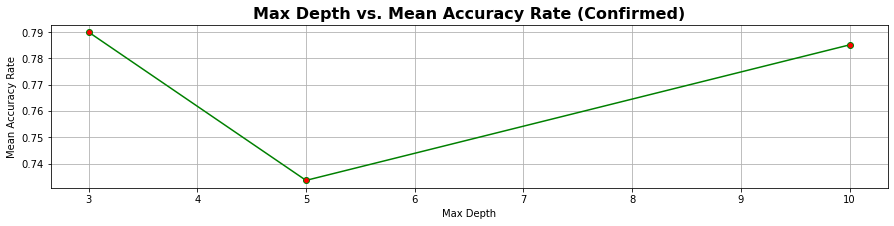

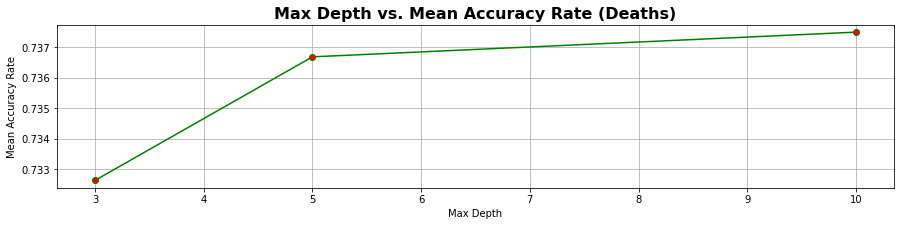

In [31]:
dtc_With_Validation_Confirmed_SMOTE= dtc_With_Validation(x_Confirmed,y_sm_Confirmed,'Confirmed')
dtc_With_Validation_Deaths_SMOTE= dtc_With_Validation(x_Deaths,y_sm_Deaths,'Deaths')

### Hyper Parameter tuning( max_depth) without validation:

In [32]:
def dtc_Without_Validation(x,y,str1):
    # accuracies using training set without validation
    scores=[]
    maxDepth=[3,5,10,None]
    for i in maxDepth:
        tree= DecisionTreeClassifier(max_depth=i).fit(x,y)
        scores.append(accuracy_score(y,tree.predict(x))) 
    # Plotting graph of Max Depth vs. Accuracy Rate without validation
    plt.figure(figsize=(15,3))
    plt.plot(maxDepth,scores,marker='o',markerfacecolor='r',color='g')
    plt.xlabel("Max Depth")
    plt.ylabel("Mean Accuracy Rate")
    plt.title("Max Depth vs. Mean Accuracy Rate without validation({})".format(str1), fontsize=16, fontweight='bold')
    plt.grid()
    scores=pd.DataFrame(scores,index=["Max_depth=3","Max_depth=5","Max_depth=10","Max_depth=None"],columns=['Training_Set_Accuracy'])

    # Printing exact accuracies
    print('The accuracy scores without K-Fold CrossValidation are({})'.format(str1))
    display(scores)

### Without SMOTE:

The accuracy scores without K-Fold CrossValidation are(Combined)


,Training_Set_Accuracy
Max_depth=3,0.751449
Max_depth=5,0.838406
Max_depth=10,0.936232
Max_depth=None,1.000000


The accuracy scores without K-Fold CrossValidation are(Confirmed)


,Training_Set_Accuracy
Max_depth=3,0.965942
Max_depth=5,0.971739
Max_depth=10,0.988406
Max_depth=None,1.000000


The accuracy scores without K-Fold CrossValidation are(Deaths)


,Training_Set_Accuracy
Max_depth=3,0.923913
Max_depth=5,0.934058
Max_depth=10,0.976087
Max_depth=None,1.000000


The accuracy scores without K-Fold CrossValidation are(Recovered)


,Training_Set_Accuracy
Max_depth=3,0.828261
Max_depth=5,0.905072
Max_depth=10,0.980435
Max_depth=None,1.000000


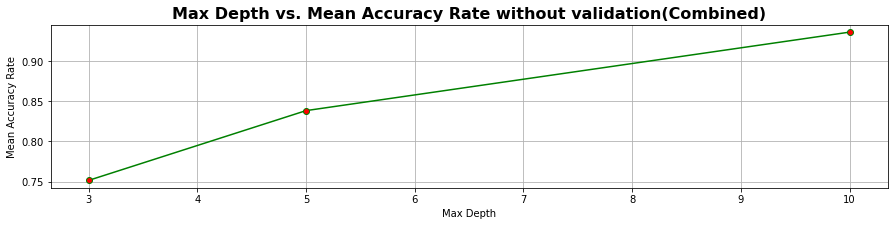

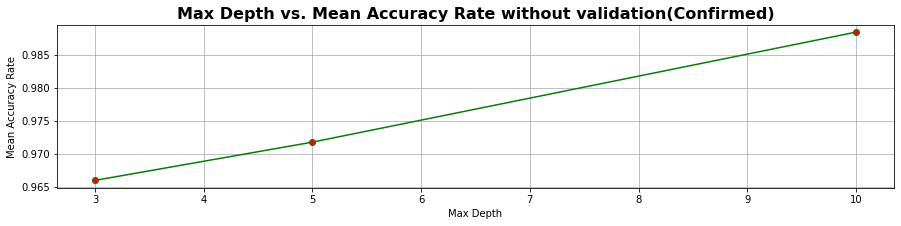

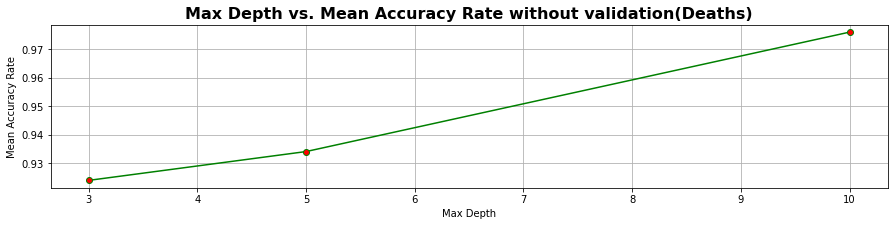

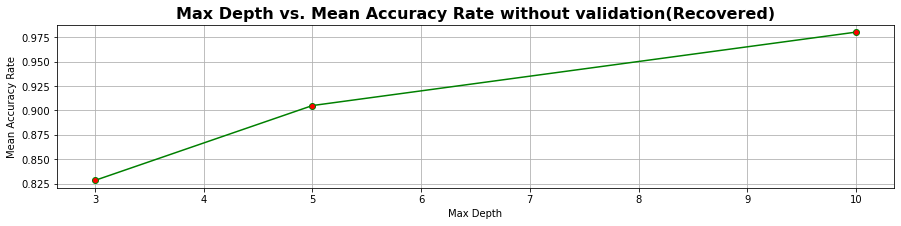

In [33]:
dtc_Without_Validation_Combined= dtc_Without_Validation(x_train,y_train,'Combined')
dtc_Without_Validation_Confirmed= dtc_Without_Validation(x_train,y_train['Confirmed'],'Confirmed')
dtc_Without_Validation_Deaths= dtc_Without_Validation(x_train,y_train['Deaths'],'Deaths')
dtc_Without_Validation_Recovered= dtc_Without_Validation(x_train,y_train['Recovered'],'Recovered')

### With SMOTE:

The accuracy scores without K-Fold CrossValidation are(Confirmed)


,Training_Set_Accuracy
Max_depth=3,0.867946
Max_depth=5,0.885252
Max_depth=10,0.963506
Max_depth=None,1.000000


The accuracy scores without K-Fold CrossValidation are(Deaths)


,Training_Set_Accuracy
Max_depth=3,0.808682
Max_depth=5,0.874196
Max_depth=10,0.939309
Max_depth=None,1.000000


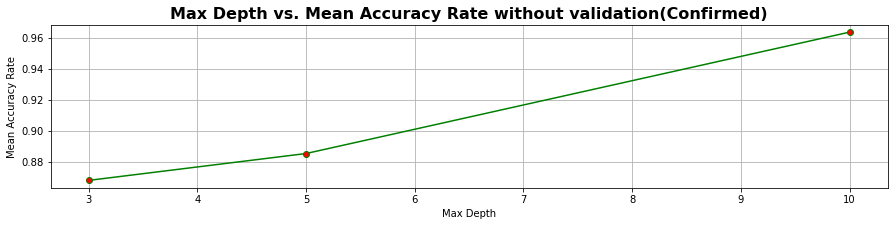

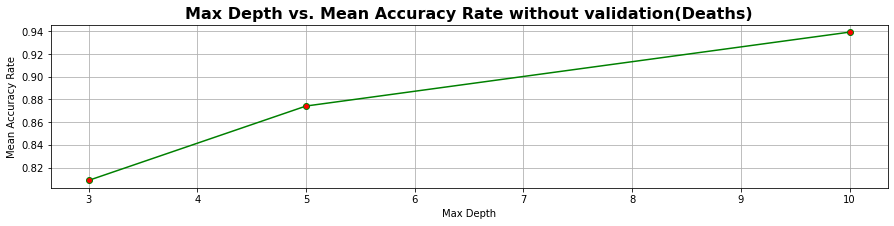

In [34]:
dtc_Without_Validation_Confirmed_SMOTE= dtc_Without_Validation(x_Confirmed,y_sm_Confirmed,'Confirmed')
dtc_Without_Validation_Deaths_SMOTE= dtc_Without_Validation(x_Deaths,y_sm_Deaths,'Deaths')

Here, in validation set , the maximum accuracy is reached at 5 whereas , on actual training data set 100% accuracy is achieved at default parameter None i.e., grow until leaf contains 2 elements.

### Effect on Accuracies w.r.t. Split method(criterion) and Max Depth :

accuracies of varying Split Criterion and Max depth are: 


mean_test_score                              
param_max_depth             NaN        3         5         10
param_criterion                                              
entropy                0.791304  0.740580  0.809420  0.796377
gini                   0.786957  0.746377  0.818116  0.804348

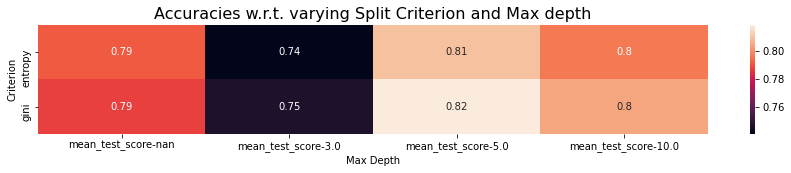

In [35]:
# setting parameters for hyperparameter tuning of criterion and max depth
dtc=DecisionTreeClassifier()
parameters1_={'criterion':['gini','entropy'],'max_depth':[3,5,10,None]}
dtc_df_=hyperparameter_tuning(dtc,parameters1_,x_train,y_train)
dtc_df_=dtc_df_[['param_criterion','param_max_depth','mean_test_score']]
dtc_df_=dtc_df_.pivot(index='param_criterion',columns='param_max_depth')

# Plotting Heatmap of Split method and Max Depth w.r.t. accuracies
plt.figure(figsize=(15,2))
sns.heatmap(dtc_df_,annot=True)
plt.xlabel("Max Depth")
plt.ylabel("Criterion")
plt.title("Accuracies w.r.t. varying Split Criterion and Max depth",fontsize=16)

# Printing exact accuracies
print('accuracies of varying Split Criterion and Max depth are: ')
display(dtc_df_)

## CM[4]:
### Random Forest Classifier

1) With Validation:
   - Without SMOTE
   
   a) Best max_depth and n_estimators for Combined targets are 5 and 200 respectively
   
   b) Best max_depth and n_estimators for 'Confirmed' targets are 5 and 200 respectively
   
   c) Best max_depth and n_estimators for 'Deaths' target are None and 50 respectively
   
   d) Best max_depth and n_estimators for 'Recovered' target are 3 and 200 respectively
   
   - With SMOTE
   
   a) Best max_depth and n_estimators for 'Confirmed' targets are 10 and 200 respectively
   
   b) Best max_depth and n_estimators for 'Deaths' target are 5 and 50 respectively
   
2) Without Validation:
   - Without SMOTE
   
   a) Best max_depth and n_estimators for Combined targets are None and 200 respectively
   
   b) Best max_depth and n_estimators for 'Confirmed' targets are None and 200 respectively
   
   c) Best max_depth and n_estimators for 'Deaths' target are None and 200 respectively
   
   d) Best max_depth and n_estimators for 'Recovered' target are None and 200 respectively
   
   - With SMOTE
   
   a) Best max_depth and n_estimators for 'Confirmed' targets are None and 200 respectively
   
   b) Best max_depth and n_estimators for 'Deaths' target are None and 200 respectively

3) PCA Features:

    a)With Validation: Best max_depth and n_estimators for targets are 10 and 200 respectively
    b)Without Validation: Best max_depth and n_estimators for targets are None and 200 respectively
 
So, best  n_estimators among all results are 200 and max_depth varies in acse of k-fold validation.here, In original max_depth=5 is good whereas, in PCA max_depth=10 is good. Although, without validation max_depth = None provides 100% accuracy. 

### Hyperparameter tuning with K-fold Cross Validation:

In [36]:
# Function that returns RandomForestClassifier accuracy with kfold cross validation
def rfc_With_validation(x,y,str1,str2):
    # initiating RandomForestClassifier() and setting hyperparameters
    rfc=RandomForestClassifier()
    parameters2={'n_estimators': [5,10,50,150,200],'max_depth': [3,5,10,None]}
    # Random Forest Classifier with 5-fold crossvalidation
    rfc_df=hyperparameter_tuning(rfc,parameters2,x,y)
    rfc_df=rfc_df[['param_n_estimators','param_max_depth','mean_test_score']]
    rfc_df=rfc_df.pivot(index='param_n_estimators',columns='param_max_depth')
    # Plotting Heatmap of accuracies achieved 
    plt.figure(figsize=(15,4))
    sns.heatmap(rfc_df,annot=True)
    plt.xlabel("Max Depth")
    plt.ylabel("No. of Trees")
    plt.title("Accuracies w.r.t. varying No. of trees and Max depth,\n using {} features and {} target(With K-fold Cross Validation)".format(str1,str2)
              ,fontsize=16)
    # Printing exact accuracies
    print('accuracies of varying No. of trees and Max depth, using {} features and {} target(With K-fold Cross Validation) are:'.format(str1,str2))
    display(rfc_df)

### Hyper Parameter tuning of No. of trees and max_depth using original features(With Validation):

### Without SMOTE:

accuracies of varying No. of trees and Max depth, using Original features and Combined target(With K-fold Cross Validation) are:


mean_test_score                              
param_max_depth                NaN        3         5         10
param_n_estimators                                              
5                         0.817391  0.780435  0.818841  0.811594
10                        0.808696  0.783333  0.826812  0.834058
50                        0.822464  0.778261  0.839855  0.829710
150                       0.820290  0.786232  0.840580  0.828261
200                       0.820290  0.791304  0.842029  0.829710

accuracies of varying No. of trees and Max depth, using Original features and Confirmed target(With K-fold Cross Validation) are:


mean_test_score                              
param_max_depth                NaN        3         5         10
param_n_estimators                                              
5                         0.852174  0.963043  0.961594  0.963043
10                        0.942754  0.955797  0.960145  0.954348
50                        0.897101  0.963043  0.963043  0.955797
150                       0.951449  0.963043  0.963043  0.952899
200                       0.953623  0.963043  0.963043  0.952899

accuracies of varying No. of trees and Max depth, using Original features and Deaths target(With K-fold Cross Validation) are:


mean_test_score                              
param_max_depth                NaN        3         5         10
param_n_estimators                                              
5                         0.878261  0.906522  0.897101  0.883333
10                        0.876812  0.913768  0.906522  0.885507
50                        0.878261  0.914493  0.904348  0.886957
150                       0.882609  0.914493  0.901449  0.886232
200                       0.879710  0.914493  0.901449  0.888406

accuracies of varying No. of trees and Max depth, using Original features and Recovered target(With K-fold Cross Validation) are:


mean_test_score                              
param_max_depth                NaN        3         5         10
param_n_estimators                                              
5                         0.921739  0.860870  0.916667  0.926812
10                        0.931884  0.866667  0.927536  0.934783
50                        0.936232  0.873188  0.934783  0.932609
150                       0.934783  0.868116  0.934783  0.935507
200                       0.931884  0.871014  0.933333  0.934783

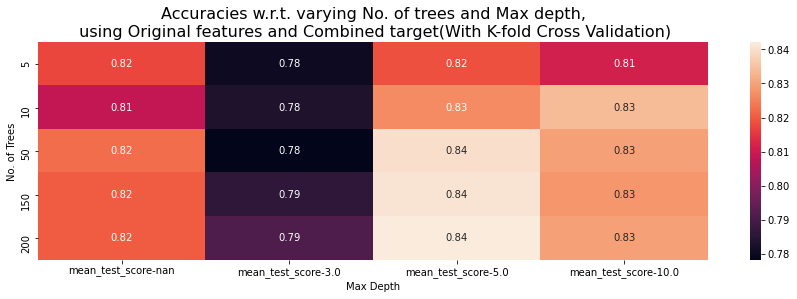

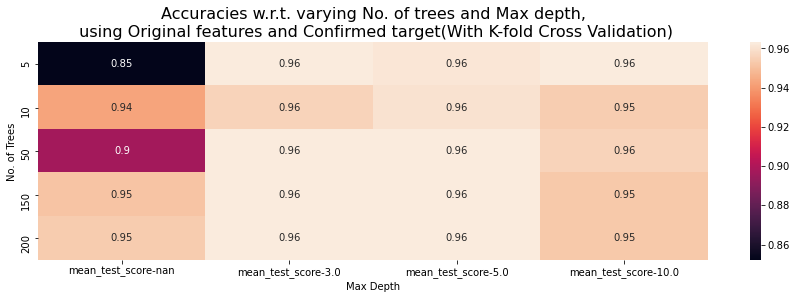

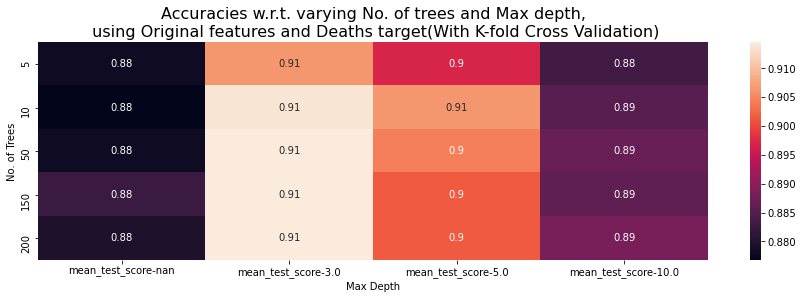

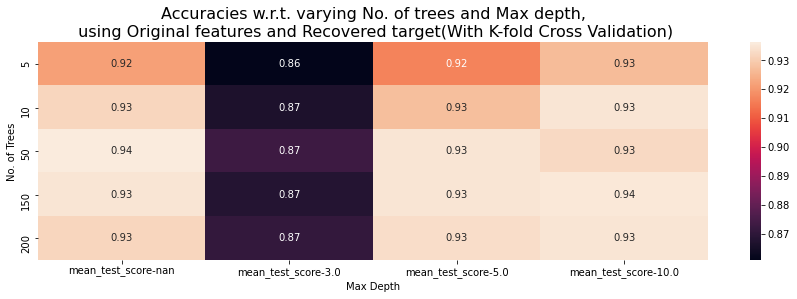

In [37]:
rfc_With_Validation_Original_Combined=rfc_With_validation(x_train,y_train,'Original','Combined')
rfc_With_Validation_Original_Confirmed=rfc_With_validation(x_train,y_train['Confirmed'],'Original','Confirmed')
rfc_With_Validation_Original_Deaths=rfc_With_validation(x_train,y_train['Deaths'],'Original','Deaths')
rfc_With_Validation_Original_Recovered=rfc_With_validation(x_train,y_train['Recovered'],'Original','Recovered')

### With SMOTE:

accuracies of varying No. of trees and Max depth, using Original features and Confirmed target(With K-fold Cross Validation) are:


mean_test_score                              
param_max_depth                NaN        3         5         10
param_n_estimators                                              
5                         0.888596  0.860063  0.841521  0.930774
10                        0.922486  0.892776  0.912324  0.928128
50                        0.915702  0.899168  0.921363  0.931515
150                       0.928508  0.899170  0.922113  0.935280
200                       0.926627  0.899172  0.924002  0.933023

accuracies of varying No. of trees and Max depth, using Original features and Deaths target(With K-fold Cross Validation) are:


mean_test_score                              
param_max_depth                NaN        3         5         10
param_n_estimators                                              
5                         0.772044  0.700850  0.738646  0.783343
10                        0.793368  0.787376  0.766420  0.758416
50                        0.764790  0.744717  0.827951  0.807447
150                       0.776072  0.766446  0.793346  0.782080
200                       0.777265  0.760390  0.785295  0.798575

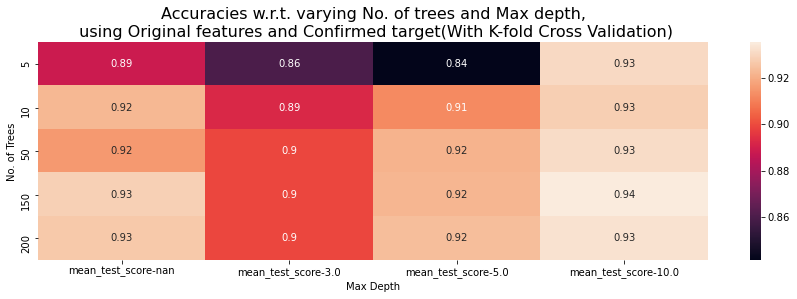

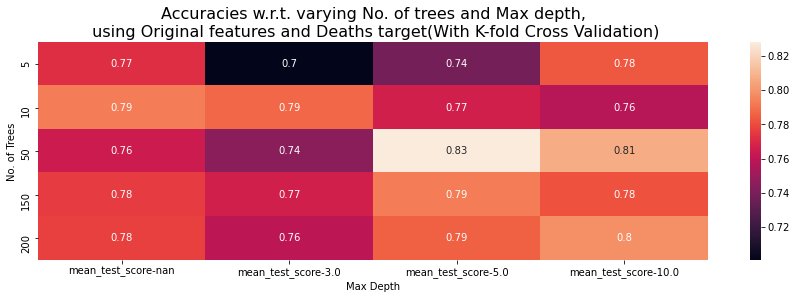

In [38]:
rfc_With_Validation_Original_Confirmed_SMOTE=rfc_With_validation(x_Confirmed,y_sm_Confirmed,'Original','Confirmed')
rfc_With_Validation_Original_Deaths_SMOTE=rfc_With_validation(x_Deaths,y_sm_Deaths,'Original','Deaths')

### Hyper Parameter tuning of  No. of trees and max_depth usinf PCA features(With Validation):

accuracies of varying No. of trees and Max depth, using PCA features and Combined target(With K-fold Cross Validation) are:


mean_test_score                              
param_max_depth                NaN        3         5         10
param_n_estimators                                              
5                         0.790580  0.719565  0.786957  0.813768
10                        0.803623  0.722464  0.786232  0.816667
50                        0.817391  0.748551  0.808696  0.830435
150                       0.815217  0.745652  0.829710  0.832609
200                       0.817391  0.748551  0.818841  0.833333

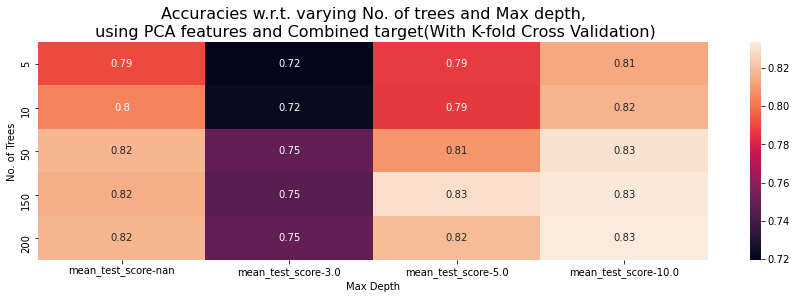

In [39]:
# Retreiving PCA data for Random Forest Classifier
pca_rfc=pca(x_train,9)

# Random Forest Classifier using PCA data
rfc_With_Validation_PCA=rfc_With_validation(pca_rfc,y_train,'PCA','Combined')

### Hyperparameter tuning without Validation:

In [40]:
# Function that returns RandomForestClassifier accuracy without validation
def rfc_Without_validation(x,y,str1,str2):
    rfc_scores=np.zeros((5,4))
    nEstimators=[5,10,50,150,200]
    maxDepth=[3,5,10,None]
    for i in range(len(nEstimators)):
        for j in range(len(maxDepth)):
            rfc1= RandomForestClassifier(n_estimators=nEstimators[i], max_depth=maxDepth[j]).fit(x_train,y_train)
            rfc_scores[i][j]= (accuracy_score(y_train,rfc1.predict(x_train)))
    # Creating dataframe of accuracies
    rfc_scores=pd.DataFrame(rfc_scores,columns=["Max_depth=3","Max_depth=5","Max_depth=10","Max_depth=None"])
    rfc_scores['No. of trees']=nEstimators
    rfc_scores.set_index('No. of trees',inplace=True)
    
    # Plotting Heatmap of accuracies achieved without validation
    plt.figure(figsize=(15,4))
    sns.heatmap(rfc_scores,annot=True)
    plt.title("Accuracies w.r.t. varying No. of trees and Max depth, using {} features and {} target(w/o validation)".format(str1,str2),fontsize=16)
    # Printing exact accuracies
    print('accuracies of varying No. of trees and Max depth, using {} features and {} target(w/o validation) are: '.format(str1,str2))
    display(rfc_scores)

### Hyperparameter tuning on original features(Without Validation):

### Without SMOTE:

accuracies of varying No. of trees and Max depth, using Original features and Combined target(w/o validation) are: 


,Max_depth=3,Max_depth=5,Max_depth=10,Max_depth=None
No. of trees,,,,
5,0.784783,0.857246,0.913768,0.974638
10,0.794928,0.846377,0.928261,0.981884
50,0.813768,0.843478,0.928986,0.997826
150,0.766667,0.851449,0.925362,1.000000
200,0.790580,0.856522,0.928261,1.000000


accuracies of varying No. of trees and Max depth, using Original features and Confirmed target(w/o validation) are: 


,Max_depth=3,Max_depth=5,Max_depth=10,Max_depth=None
No. of trees,,,,
5,0.770290,0.830435,0.928261,0.975362
10,0.751449,0.855797,0.930435,0.986232
50,0.781884,0.863768,0.923913,0.995652
150,0.797101,0.853623,0.923913,1.000000
200,0.797826,0.854348,0.924638,1.000000


accuracies of varying No. of trees and Max depth, using Original features and Deaths target(w/o validation) are: 


,Max_depth=3,Max_depth=5,Max_depth=10,Max_depth=None
No. of trees,,,,
5,0.785507,0.857246,0.921014,0.963043
10,0.781884,0.852899,0.920290,0.981884
50,0.808696,0.855797,0.927536,0.997826
150,0.797101,0.852899,0.923188,1.000000
200,0.776812,0.854348,0.928986,1.000000


accuracies of varying No. of trees and Max depth, using Original features and Recovered target(w/o validation) are: 


,Max_depth=3,Max_depth=5,Max_depth=10,Max_depth=None
No. of trees,,,,
5,0.803623,0.813043,0.932609,0.963043
10,0.760145,0.841304,0.928261,0.980435
50,0.810870,0.852899,0.926087,0.998551
150,0.797101,0.851449,0.916667,1.000000
200,0.810145,0.853623,0.927536,1.000000


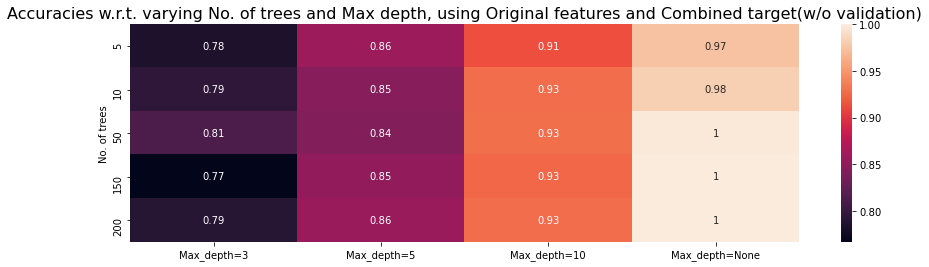

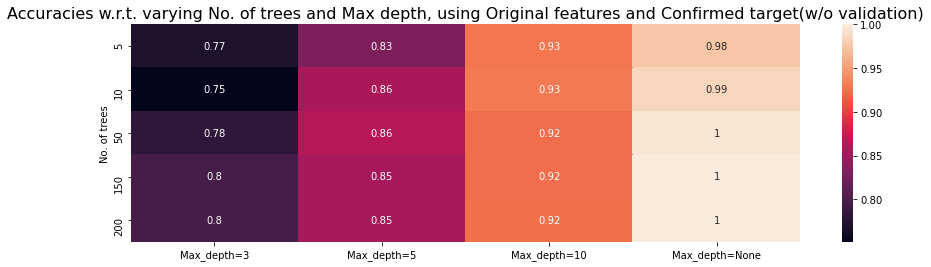

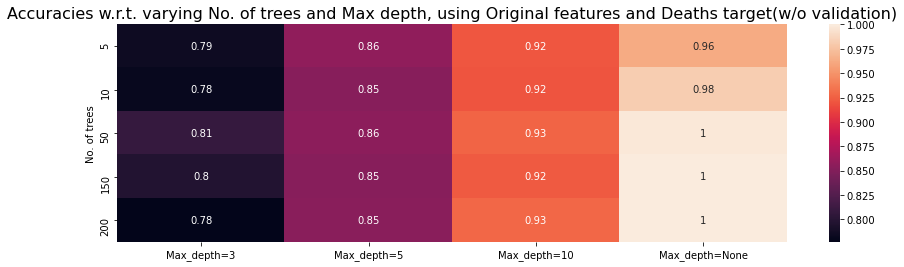

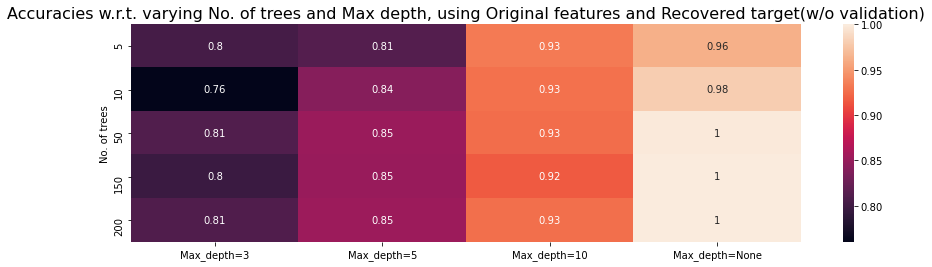

In [41]:
rfc_Without_Validation_Original_Combined=rfc_Without_validation(x_train,y_train,'Original','Combined')
rfc_Without_Validation_Original_Confirmed=rfc_Without_validation(x_train,y_train['Confirmed'],'Original','Confirmed')
rfc_Without_Validation_Original_Deaths=rfc_Without_validation(x_train,y_train['Deaths'],'Original','Deaths')
rfc_Without_Validation_Original_Recovered=rfc_Without_validation(x_train,y_train['Recovered'],'Original','Recovered')

### With SMOTE:

accuracies of varying No. of trees and Max depth, using Original features and Confirmed target(w/o validation) are: 


,Max_depth=3,Max_depth=5,Max_depth=10,Max_depth=None
No. of trees,,,,
5,0.797826,0.804348,0.924638,0.968841
10,0.807246,0.844928,0.920290,0.984058
50,0.769565,0.855797,0.923913,0.997826
150,0.793478,0.857246,0.923188,1.000000
200,0.812319,0.852899,0.926087,1.000000


accuracies of varying No. of trees and Max depth, using Original features and Deaths target(w/o validation) are: 


,Max_depth=3,Max_depth=5,Max_depth=10,Max_depth=None
No. of trees,,,,
5,0.797101,0.856522,0.922464,0.974638
10,0.803623,0.853623,0.928986,0.982609
50,0.804348,0.851449,0.923913,0.998551
150,0.795652,0.855072,0.930435,1.000000
200,0.782609,0.853623,0.920290,1.000000


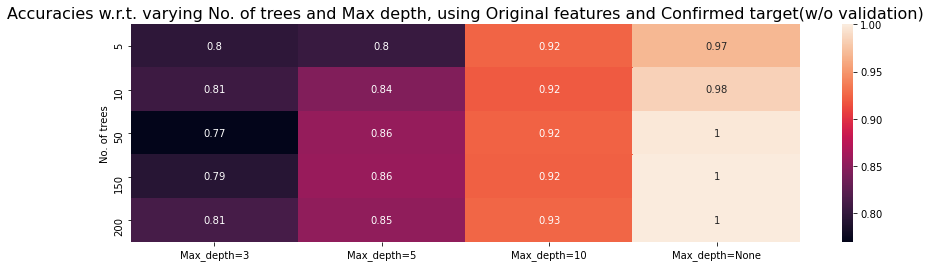

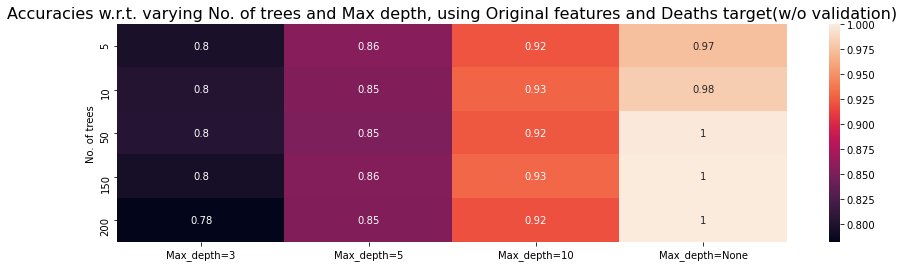

In [42]:
rfc_Without_Validation_Original_Confirmed_SMOTE=rfc_Without_validation(x_Confirmed,y_sm_Confirmed,'Original','Confirmed')
rfc_Without_Validation_Original_Deaths_SMOTE=rfc_Without_validation(x_Deaths,y_sm_Deaths,'Original','Deaths')

### Hyperparameter tuning on PCA features(Without Validation):

accuracies of varying No. of trees and Max depth, using PCA features and Combined target(w/o validation) are: 


,Max_depth=3,Max_depth=5,Max_depth=10,Max_depth=None
No. of trees,,,,
5,0.760870,0.861594,0.917391,0.968116
10,0.760870,0.854348,0.915217,0.981884
50,0.785507,0.851449,0.920290,0.997101
150,0.810870,0.853623,0.926087,1.000000
200,0.797101,0.852899,0.924638,1.000000


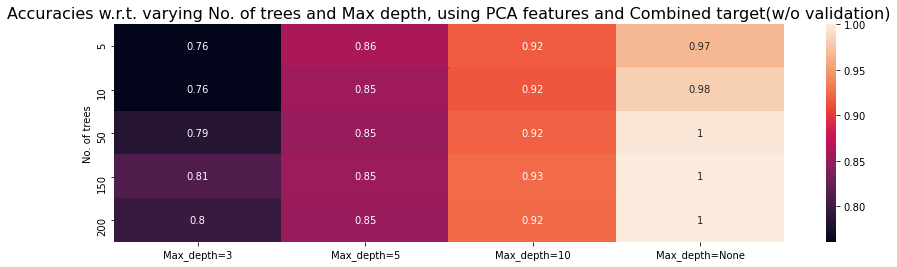

In [43]:
rfc_Without_Validation_PCA=rfc_Without_validation(pca_rfc,y_train,'PCA','Combined')

From PCA features, it is observed that the maximum accuracy is achieved at no. of trees = 150 and 200 and max depth = 5 and 10, but common among both maximum accuracy is achievedat no. of trees =150 and max_depth= 10. Also, looking individually at each feature, they have both have good results among their range.

## CM[5]:
### Gradient Boosting Classifier:
1) With Validation:
   - Without SMOTE
   
   a) Best n_estimators for Combined targets is 50
   
   b) Best n_estimators for 'Confirmed' targets is 5
   
   c) Best n_estimators for 'Deaths' target is 10
   
   d) Best n_estimators for 'Recovered' target is 50
   
   - With SMOTE
   
   a) Best n_estimators for 'Confirmed' targets is 150
   
   b) Best n_estimators for 'Deaths' target is 5
   
2) Without Validation:
   - Without SMOTE
   
   a) Best n_estimators for Combined targets is 200
   
   b) Best n_estimators for 'Confirmed' targets is 200
   
   c) Best n_estimators for 'Deaths' target is 200
   
   d) Best n_estimators for 'Recovered' target is 200
   
   - With SMOTE
   
   a) Best n_estimators for 'Confirmed' targets is 200
   
   b) Best n_estimators for 'Deaths' target is 200
   
3) PCA Features:

   a)With Validation: Best  n_estimators for targets is 50
   
   b)Without Validation: Best  n_estimators for targets is 200
 
So, n_estimators here treats every target differently and , in maximum cases(both original and PCA) n_estimators=50 performed better in validation whereas, without validation 200 no. of trees performs better. Although, their combination may provide better results.

### Hyperparameter tuning with K-fold Cross Validation:

In [44]:
# Function that returns GradientBoostingClassifier accuracy with kfold cross validation
def gbc_With_validation(x,y,str1,str2):
    # GradientBoostingClassifier using kfold cross validation on original data
    # setting hyperparameters
    nEstimators=[5,10,50,150,200]
    gbc_df=[]
    for i in nEstimators:
        if str2=='Combined':
            # applying multioutput on GradientBoostingClassifier, as there are multiple targets
            gbc=multioutput.MultiOutputClassifier(GradientBoostingClassifier(n_estimators=i))
        else:
            gbc=GradientBoostingClassifier(n_estimators=i)
        gbc_df.append((cross_val_score(gbc,x,y,cv=5)).mean())
        
    # Converting list to dataframe
    gbc_df=pd.DataFrame(gbc_df,columns=['Mean Accuracy rate'])
    gbc_df['n_estimators']=nEstimators
    gbc_df.set_index('n_estimators',inplace=True)
    
    # Plotting graph of No. of Trees vs. Accuracy Rate on original features
    plt.figure(figsize=(15,3))
    plt.plot(nEstimators,gbc_df['Mean Accuracy rate'],marker='o',markerfacecolor='r',color='g')
    plt.xlabel("No. of estimators")
    plt.ylabel(" Mean Accuracy Rate")
    plt.title("No. of estimators vs. Accuracy Rate on {} features and {} target(With Cross Validation)".format(str1,str2), fontsize=16, fontweight='bold')
    plt.grid()
    # Printing exact values
    print("Accuracies w.r.t. varying No. of estimators, using  {} features and {} target(With Cross Validation): ".format(str1,str2))
    display(gbc_df)

### Hyper Parameter tuning( n_estimators), using Original features(With Validation):

### Without SMOTE:

Accuracies w.r.t. varying No. of estimators, using  Original features and Combined target(With Cross Validation): 


,Mean Accuracy rate
n_estimators,
5,0.748551
10,0.797826
50,0.840580
150,0.832609
200,0.826087


Accuracies w.r.t. varying No. of estimators, using  Original features and Confirmed target(With Cross Validation): 


,Mean Accuracy rate
n_estimators,
5,0.936957
10,0.813043
50,0.813768
150,0.886232
200,0.898551


Accuracies w.r.t. varying No. of estimators, using  Original features and Deaths target(With Cross Validation): 


,Mean Accuracy rate
n_estimators,
5,0.901449
10,0.911594
50,0.892029
150,0.886232
200,0.884783


Accuracies w.r.t. varying No. of estimators, using  Original features and Recovered target(With Cross Validation): 


,Mean Accuracy rate
n_estimators,
5,0.828261
10,0.873188
50,0.936232
150,0.935507
200,0.934058


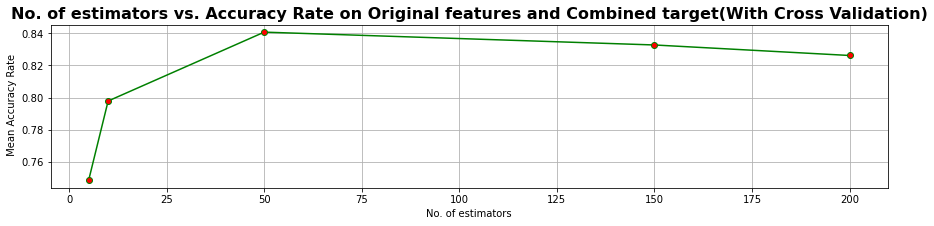

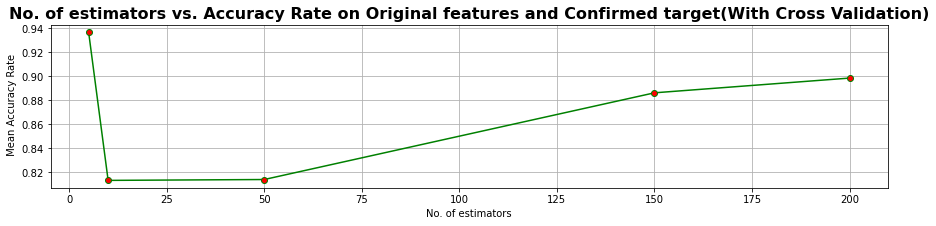

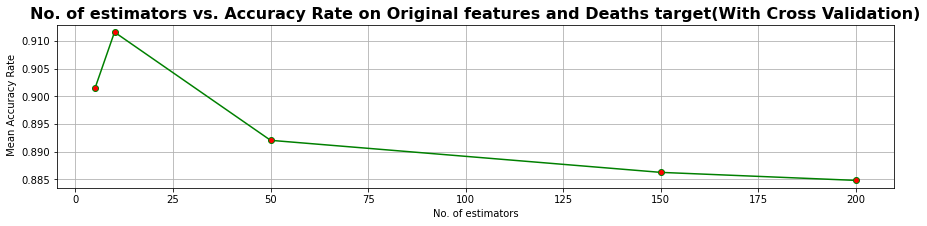

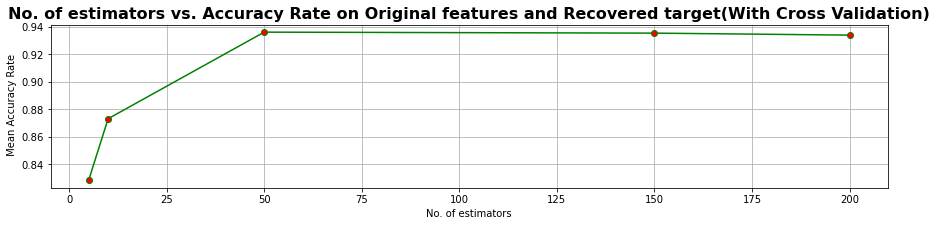

In [45]:
gbc_With_CV_Original_Combined=gbc_With_validation(x_train,y_train,'Original','Combined')
gbc_With_CV_Original_Confirmed=gbc_With_validation(x_train,y_train['Confirmed'],'Original','Confirmed')
gbc_With_CV_Original_Deaths=gbc_With_validation(x_train,y_train['Deaths'],'Original','Deaths')
gbc_With_CV_Original_Recovered=gbc_With_validation(x_train,y_train['Recovered'],'Original','Recovered')

### With SMOTE:

Accuracies w.r.t. varying No. of estimators, using  Original features and Confirmed target(With Cross Validation): 


,Mean Accuracy rate
n_estimators,
5,0.780186
10,0.833637
50,0.874278
150,0.875410
200,0.875036


Accuracies w.r.t. varying No. of estimators, using  Original features and Deaths target(With Cross Validation): 


,Mean Accuracy rate
n_estimators,
5,0.748303
10,0.722214
50,0.696908
150,0.683646
200,0.688475


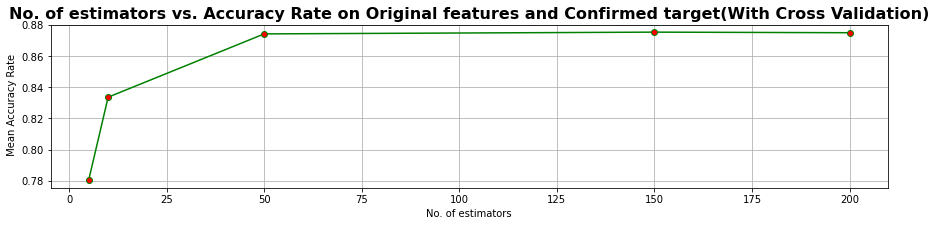

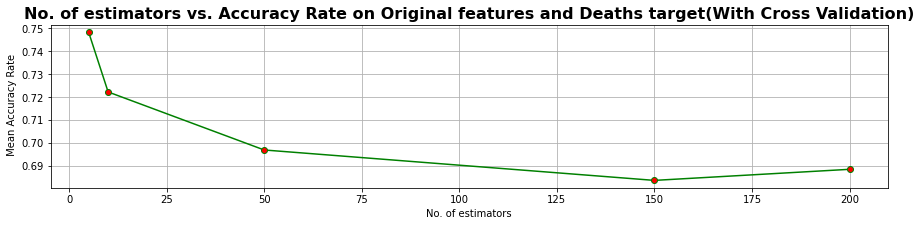

In [46]:
gbc_With_CV_Original_Confirmed_SMOTE=gbc_With_validation(x_Confirmed,y_sm_Confirmed,'Original','Confirmed')
gbc_With_CV_Original_Deaths_SMOTE=gbc_With_validation(x_Deaths,y_sm_Deaths,'Original','Deaths')

### Hyper Parameter tuning( n_estimators), using PCA features(With Validation):

Accuracies w.r.t. varying No. of estimators, using  PCA features and Combined target(With Cross Validation): 


,Mean Accuracy rate
n_estimators,
5,0.716667
10,0.754348
50,0.812319
150,0.805797
200,0.806522


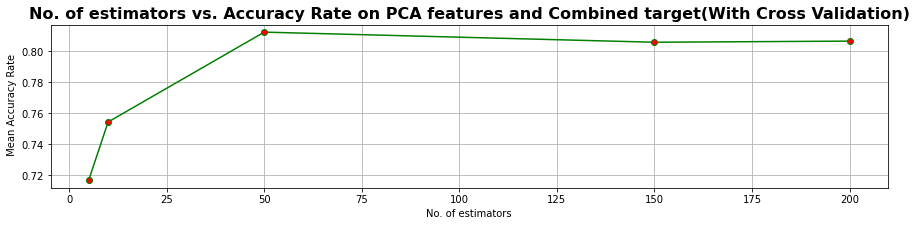

In [47]:
# Retreiving PCA data for PCA data
pca_gbc= pca(x_train,9)

# GradientBoostingClassifier using kfold cross validation on PCA data
gbc_With_CV_PCA=gbc_With_validation(pca_gbc,y_train,'PCA','Combined')

### Hyperparameter tuning without Validation:

In [48]:
# Function that returns GradientBoostingClassifier accuracy without validation
def gbc_Without_validation(x,y,str1,str2):
    # accuracies using training set without validation
    scores=[]
    nEstimators=[5,10,50,150,200]
    for i in nEstimators:
        if str2=='Combined':
            gbc=multioutput.MultiOutputClassifier(GradientBoostingClassifier(n_estimators=i)).fit(x,y)
        else:
            gbc=GradientBoostingClassifier(n_estimators=i).fit(x,y)
        scores.append(accuracy_score(y,gbc.predict(x))) 
    # Plotting graph of Max Depth vs. Accuracy Rate without validation
    plt.figure(figsize=(15,3))
    plt.plot(nEstimators,scores,marker='o',markerfacecolor='r',color='g')
    plt.xlabel("No. of estimators")
    plt.ylabel("Mean Accuracy Rate")
    plt.title("No. of estimators vs. Mean Accuracy Rateon {} features and {} target(Without validation)".format(str1,str2), fontsize=16,
             fontweight='bold')
    plt.grid()
    
    # Converting list to dataframe
    scores=pd.DataFrame(scores,columns=['Training_Set_Accuracy'])
    scores['n_estimators']=nEstimators
    scores.set_index('n_estimators',inplace=True)

    # Printing exact accuracies
    print('The accuracy scores on {} features and {} target(Without validation) are:'.format(str1,str2))
    display(scores)

### Hyperparameter tuning on original features(Without validation):

### Without SMOTE:

The accuracy scores on Original features and Combined target(Without validation) are:


,Training_Set_Accuracy
n_estimators,
5,0.748551
10,0.801449
50,0.892754
150,0.936232
200,0.953623


The accuracy scores on Original features and Confirmed target(Without validation) are:


,Training_Set_Accuracy
n_estimators,
5,0.964493
10,0.966667
50,0.977536
150,0.997101
200,0.999275


The accuracy scores on Original features and Deaths target(Without validation) are:


,Training_Set_Accuracy
n_estimators,
5,0.901449
10,0.921014
50,0.944203
150,0.968841
200,0.977536


The accuracy scores on Original features and Recovered target(Without validation) are:


,Training_Set_Accuracy
n_estimators,
5,0.828261
10,0.868841
50,0.941304
150,0.965217
200,0.974638


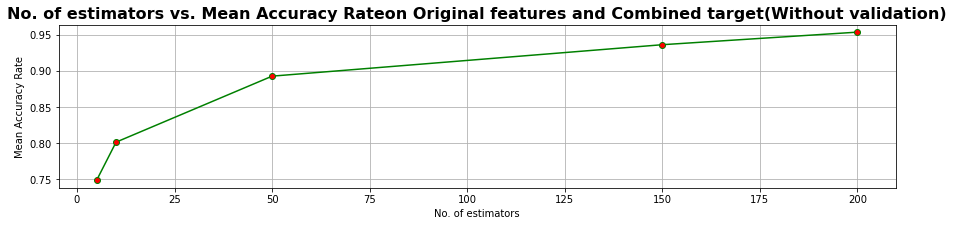

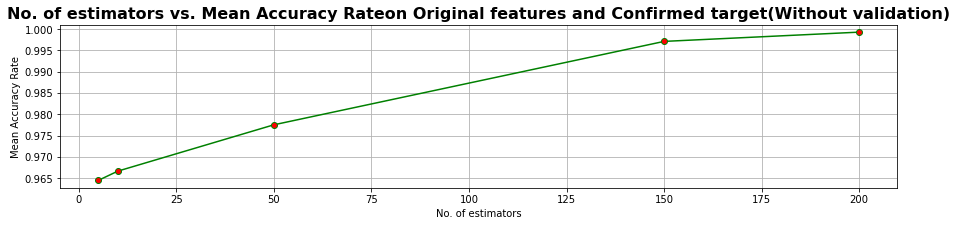

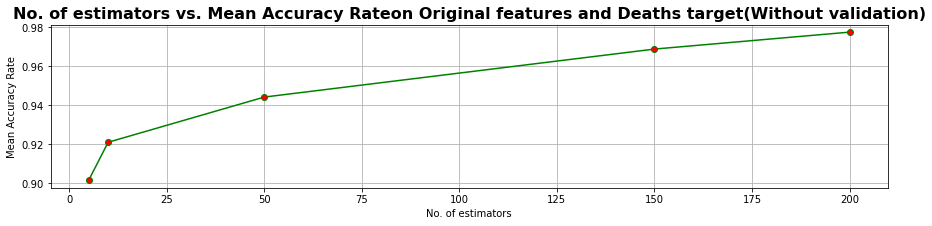

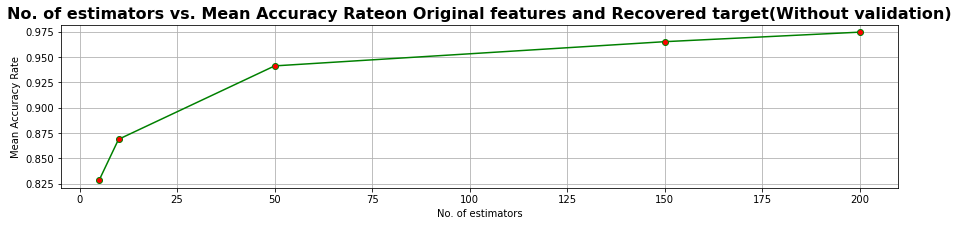

In [49]:
gbc_Without_CV_Original_Combined=gbc_Without_validation(x_train,y_train,'Original','Combined')
gbc_Without_CV_Original_Confirmed=gbc_Without_validation(x_train,y_train['Confirmed'],'Original','Confirmed')
gbc_Without_CV_Original_Deaths=gbc_Without_validation(x_train,y_train['Deaths'],'Original','Deaths')
gbc_Without_CV_Original_Recovered=gbc_Without_validation(x_train,y_train['Recovered'],'Original','Recovered')

### With SMOTE:

The accuracy scores on Original features and Confirmed target(Without validation) are:


,Training_Set_Accuracy
n_estimators,
5,0.871332
10,0.916855
50,0.944319
150,0.959744
200,0.964259


The accuracy scores on Original features and Deaths target(Without validation) are:


,Training_Set_Accuracy
n_estimators,
5,0.842444
10,0.840032
50,0.873794
150,0.913183
200,0.923232


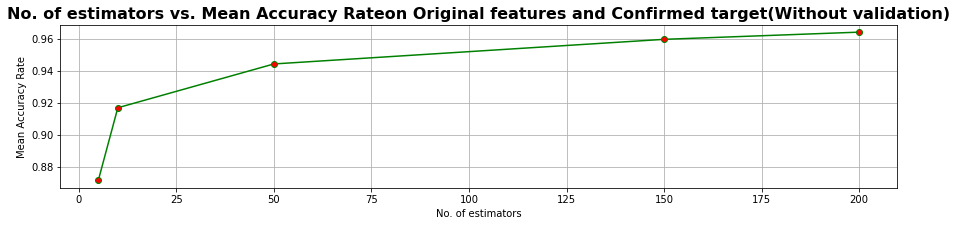

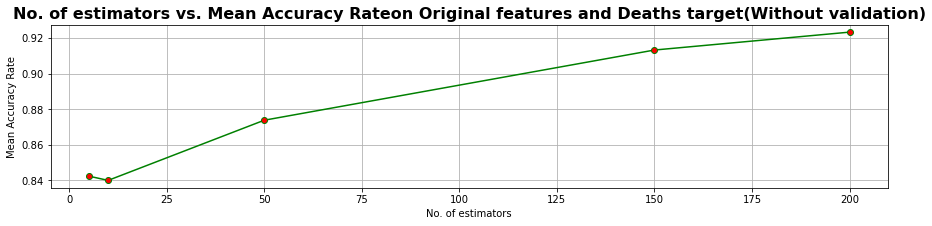

In [50]:
gbc_Without_CV_Original_Confirmed_SMOTE=gbc_Without_validation(x_Confirmed,y_sm_Confirmed,'Original','Confirmed')
gbc_Without_CV_Original_Deaths_SMOTE=gbc_Without_validation(x_Deaths,y_sm_Deaths,'Original','Deaths')

### Hyperparameter tuning on PCA features(Without validation):

The accuracy scores on PCA features and Combined target(Without validation) are:


,Training_Set_Accuracy
n_estimators,
5,0.781159
10,0.801449
50,0.893478
150,0.944928
200,0.959420


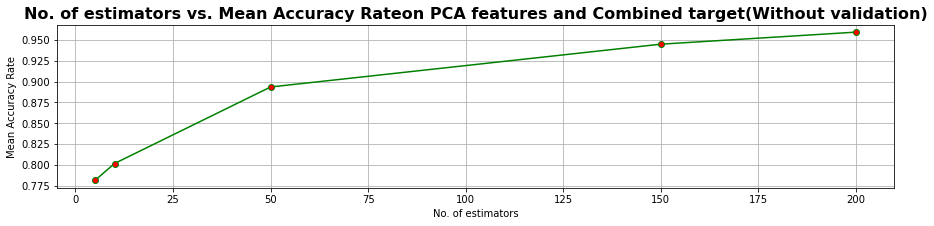

In [51]:
gbc_Without_Validation_PCA= gbc_Without_validation(pca_gbc,y_train,'PCA','Combined')

## CM[6]:
### Naive Bayes Classifier

1) With Validation:
   - Without SMOTE
   
   a) Best var_smoothing for Combined targets is 1e-1
   
   b) Best var_smoothing for 'Confirmed' targets is 1e-10
   
   c) Best var_smoothing for 'Deaths' target is 1e-1
   
   d) Best var_smoothing for 'Recovered' target is 1e-10
   
   - With SMOTE
   
   a) Best var_smoothing for 'Confirmed' targets is 1e-10
   
   b) Best var_smoothing for 'Deaths' target is 1e-10
   
2) Without Validation:
   - Without SMOTE
   
   a) Best var_smoothing for Combined targets is 1e-1
   
   b) Best var_smoothing for 'Confirmed' targets is 1e-1
   
   c) Best var_smoothing for 'Deaths' target is 1e-1
   
   d) Best var_smoothing for 'Recovered' target is 1e-10
   
   - With SMOTE
   
   a) Best var_smoothing for 'Confirmed' targets is 1e-10
   
   b) Best var_smoothing for 'Deaths' target is 1e-10

So, var_smoothing here treats every target differently and ,as recovered feature is balanced target in first thus proved better results at 1e-10 in both cases. Also, when we balance other features with SMOTE var_smoothing provides better accuracies at  1e-10. So, it can be said that for balanced data , max accuracy is achieved at 1e-10 and for imabalanced target or combination of targets maximum accuracy is achieved at 1e-1.

-Thus, here smoothing impacts at the type of data, in imbalanced , it performed well with less value of var_smoothing and for balanced data it performed well with huge value of var_smoothing. So, it can be said that it performs different with imbalanced data.Thus, as its value increases it is less suitable for imbalanced data and more suitable for balanced data. Also, it ensures that all feature values have non-zero probability.

### Hyperparameter tuning with 10-Fold Cross Validation:

In [66]:
# Function that returns GaussianNB Classifier accuracy with kfold cross validation
def gaussianNB_Validation(x,y,output_type,col,str1):
    # setting hyperparameters
    varSmoothing=[1e-10,1e-9,1e-5,1e-3,1e-1]
    nbc_df=[]
    # for multitarget outputs
    if output_type== 'combined':
        for i in varSmoothing:
            # applying multioutput on GaussianNB Classifier, as there are multiple targets
            nbc=multioutput.MultiOutputClassifier(GaussianNB(var_smoothing=i))
            nbc_df.append((cross_val_score(nbc,x,y,cv=10)).mean())
    # for individual outputs
    elif output_type=='individually':
        if col!= None:
            y=y[col]
        for i in varSmoothing:
            # applying GaussianNB Classifier, individually
            nbc=GaussianNB(var_smoothing=i)
            nbc_df.append((cross_val_score(nbc,x,y,cv=10)).mean())
    # Converting list to dataframe
    nbc_scores=pd.DataFrame(nbc_df,columns=['Mean Accuracy rate'])
    nbc_scores['var_smoothing']=varSmoothing
    nbc_scores.set_index('var_smoothing',inplace=True)
        
    # Plotting graph of No. of Trees vs. Accuracy Rate on original features
    plt.figure(figsize=(15,3))
    plt.plot(varSmoothing,nbc_df,marker='o',markerfacecolor='r',color='g')
    plt.xlabel("var_smoothing ({})".format(output_type))
    plt.ylabel("Mean Accuracy Rate")
    plt.title("var_smoothing vs. Mean Accuracy Rate of {} target({})".format(str1,output_type), fontsize=16, fontweight='bold')
    plt.grid()
    
    # Printing exact values
    print("Accuracies w.r.t. varying var_smoothing of {} target({}): ".format(str1,output_type))
    display(nbc_scores)        

### HyperParameter tuning of var_smoothing, using Original features with 10-Fold Cross Validation(Combined):

Accuracies w.r.t. varying var_smoothing of  target(combined): 


,Mean Accuracy rate
var_smoothing,
1.000000e-10,0.331159
1.000000e-09,0.331159
1.000000e-05,0.331159
1.000000e-03,0.330435
1.000000e-01,0.403623


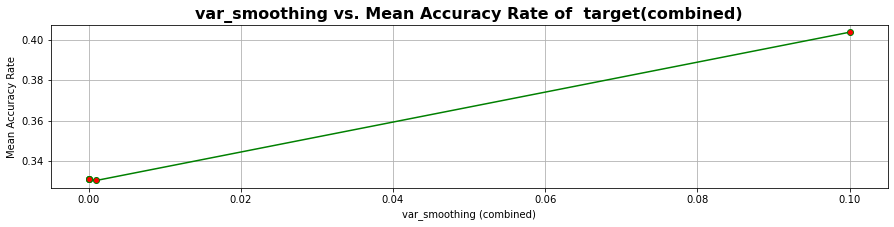

In [67]:
nbc_Combined_With_Validation=gaussianNB_Validation(x_train,y_train,'combined',None,'')

### Hyper Parameter tuning of var_smoothing, using Original features with 10-Fold Cross Validation(Individually):

### Without SMOTE:

Accuracies w.r.t. varying var_smoothing of Confirmed target(individually): 


,Mean Accuracy rate
var_smoothing,
1.000000e-10,0.731159
1.000000e-09,0.731159
1.000000e-05,0.731159
1.000000e-03,0.729710
1.000000e-01,0.787681


Accuracies w.r.t. varying var_smoothing of Deaths target(individually): 


,Mean Accuracy rate
var_smoothing,
1.000000e-10,0.640580
1.000000e-09,0.640580
1.000000e-05,0.640580
1.000000e-03,0.641304
1.000000e-01,0.731159


Accuracies w.r.t. varying var_smoothing of Recovered target(individually): 


,Mean Accuracy rate
var_smoothing,
1.000000e-10,0.708696
1.000000e-09,0.708696
1.000000e-05,0.708696
1.000000e-03,0.708696
1.000000e-01,0.695652


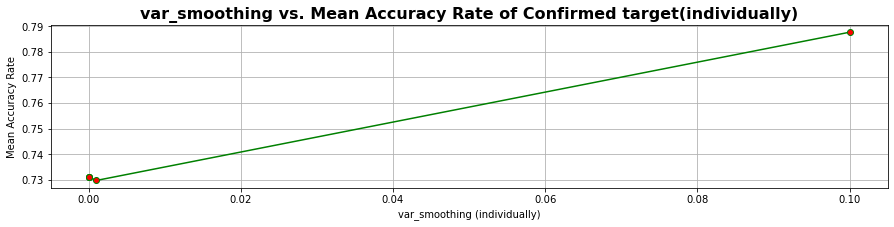

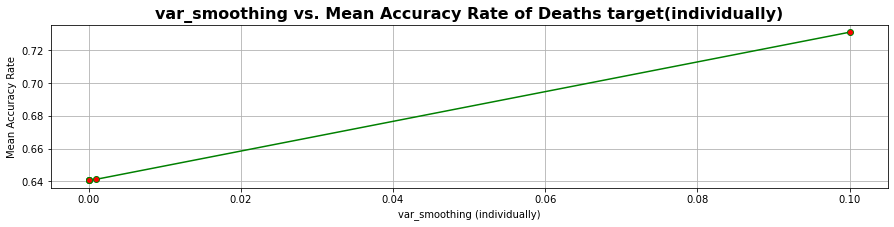

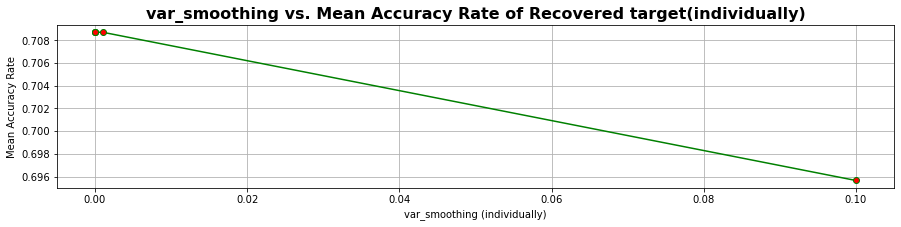

In [68]:
nbc_Confirmed_With_Validation=gaussianNB_Validation(x_train,y_train,'individually','Confirmed','Confirmed')
nbc_Deaths_With_Validation=gaussianNB_Validation(x_train,y_train,'individually','Deaths','Deaths')
nbc_Recovered_With_Validation=gaussianNB_Validation(x_train,y_train,'individually','Recovered','Recovered')

### With SMOTE:

Accuracies w.r.t. varying var_smoothing of Confirmed target(individually): 


,Mean Accuracy rate
var_smoothing,
1.000000e-10,0.748688
1.000000e-09,0.748688
1.000000e-05,0.748688
1.000000e-03,0.748312
1.000000e-01,0.671934


Accuracies w.r.t. varying var_smoothing of Deaths target(individually): 


,Mean Accuracy rate
var_smoothing,
1.000000e-10,0.627031
1.000000e-09,0.627031
1.000000e-05,0.627031
1.000000e-03,0.627031
1.000000e-01,0.613758


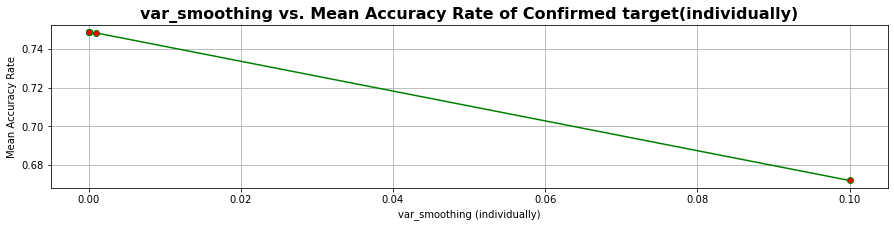

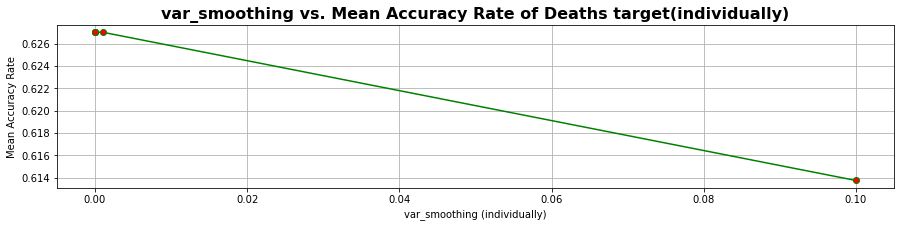

In [69]:
nbc_Confirmed_With_Validation_SMOTE=gaussianNB_Validation(x_Confirmed,y_sm_Confirmed,'individually',None,'Confirmed')
nbc_Deaths_With_Validation_SMOTE=gaussianNB_Validation(x_Deaths,y_sm_Deaths,'individually',None,'Deaths')

### Hyperparameter tuning without Validation:

In [70]:
# Function that returns GaussianNB Classifier accuracy without validation
def gaussianNB_Without_Validation(x,y,output_type,col,str1):
    # setting hyperparameters
    varSmoothing=[1e-10,1e-9,1e-5,1e-3,1e-1]
    nbc_df=[]
    # for multitarget outputs
    if(output_type== 'combined'):
        for i in varSmoothing:
            # applying multioutput on GaussianNB Classifier, as there are multiple targets
            nbc=multioutput.MultiOutputClassifier(GaussianNB(var_smoothing=i)).fit(x,y)
            nbc_df.append(accuracy_score(y,nbc.predict(x)))
    # for individual outputs
    elif(output_type=='individually'):
        if col==None:
            y=y
        else:
            y=y[col]
        for i in varSmoothing:
            # applying GaussianNB Classifier, individually
            nbc=GaussianNB(var_smoothing=i).fit(x,y)
            nbc_df.append(accuracy_score(y,nbc.predict(x)))
    # Converting list to dataframe
    nbc_scores=pd.DataFrame(nbc_df,columns=['Mean Accuracy rate'])
    nbc_scores['var_smoothing']=varSmoothing
    nbc_scores.set_index('var_smoothing',inplace=True)
        
    # Plotting graph of No. of Trees vs. Accuracy Rate on original features
    plt.figure(figsize=(15,3))
    plt.plot(varSmoothing,nbc_df,marker='o',markerfacecolor='r',color='g')
    plt.xlabel("var_smoothing ({})".format(output_type))
    plt.ylabel("Mean Accuracy Rate")
    plt.title("var_smoothing vs. Mean Accuracy Rate of {} target({} and without validation)".format(str1,output_type), fontsize=16, fontweight='bold')
    plt.grid()
    
    # Printing exact values
    print("Accuracies w.r.t. varying var_smoothing of {} target({} and without validation): ".format(str1,output_type))
    display(nbc_scores)        

### HyperParameter tuning of var_smoothing, using Original features without Validation(Combined):

Accuracies w.r.t. varying var_smoothing of  target(combined and without validation): 


,Mean Accuracy rate
var_smoothing,
1.000000e-10,0.324638
1.000000e-09,0.324638
1.000000e-05,0.324638
1.000000e-03,0.323913
1.000000e-01,0.384783


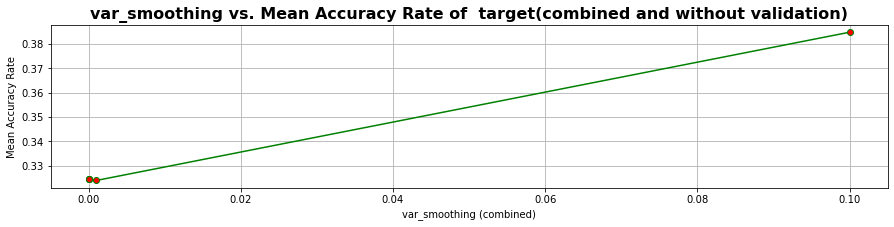

In [71]:
nbc_Combined_Without_Validation=gaussianNB_Without_Validation(x_train,y_train,'combined',None,'')

### Hyper Parameter tuning of var_smoothing, using Original features without Validation(Individually):

### Without SMOTE:

Accuracies w.r.t. varying var_smoothing of Confirmed target(individually and without validation): 


,Mean Accuracy rate
var_smoothing,
1.000000e-10,0.726087
1.000000e-09,0.726087
1.000000e-05,0.726087
1.000000e-03,0.724638
1.000000e-01,0.770290


Accuracies w.r.t. varying var_smoothing of Deaths target(individually and without validation): 


,Mean Accuracy rate
var_smoothing,
1.000000e-10,0.647826
1.000000e-09,0.647826
1.000000e-05,0.647826
1.000000e-03,0.650000
1.000000e-01,0.734783


Accuracies w.r.t. varying var_smoothing of Recovered target(individually and without validation): 


,Mean Accuracy rate
var_smoothing,
1.000000e-10,0.707971
1.000000e-09,0.707971
1.000000e-05,0.707971
1.000000e-03,0.707971
1.000000e-01,0.695652


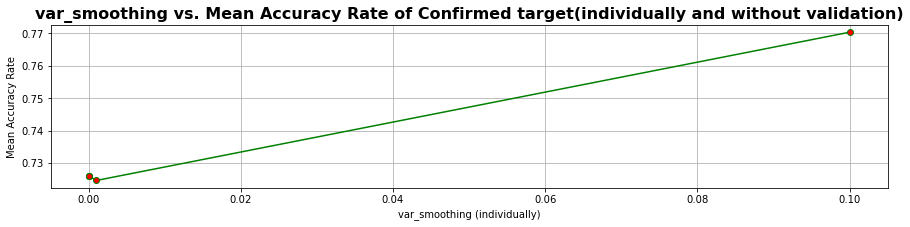

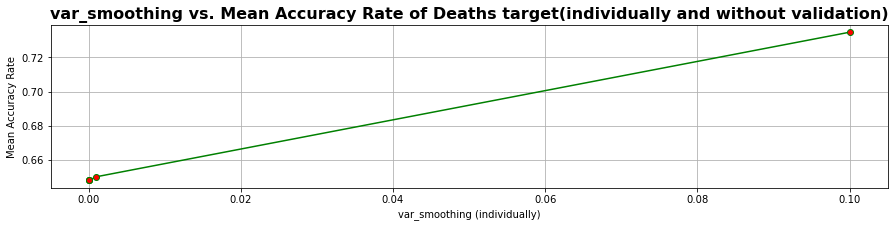

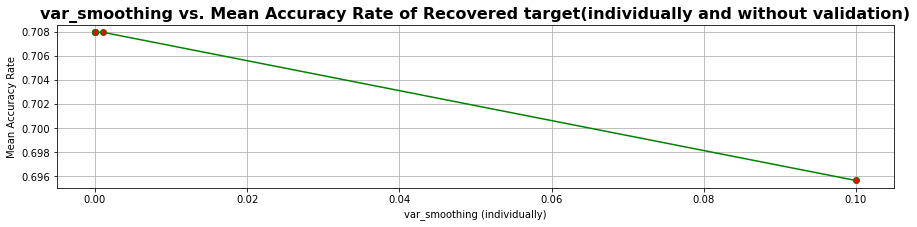

In [72]:
nbc_Confirmed_Without_Validation=gaussianNB_Without_Validation(x_train,y_train,'individually','Confirmed','Confirmed')
nbc_Deaths_Without_Validation=gaussianNB_Without_Validation(x_train,y_train,'individually','Deaths','Deaths')
nbc_Recovered_Without_Validation=gaussianNB_Without_Validation(x_train,y_train,'individually','Recovered','Recovered')

### With SMOTE:

Accuracies w.r.t. varying var_smoothing of Confirmed target(individually and without validation): 


,Mean Accuracy rate
var_smoothing,
1.000000e-10,0.750564
1.000000e-09,0.750564
1.000000e-05,0.750564
1.000000e-03,0.750564
1.000000e-01,0.697141


Accuracies w.r.t. varying var_smoothing of Deaths target(individually and without validation): 


,Mean Accuracy rate
var_smoothing,
1.000000e-10,0.632235
1.000000e-09,0.632235
1.000000e-05,0.632235
1.000000e-03,0.631431
1.000000e-01,0.617765


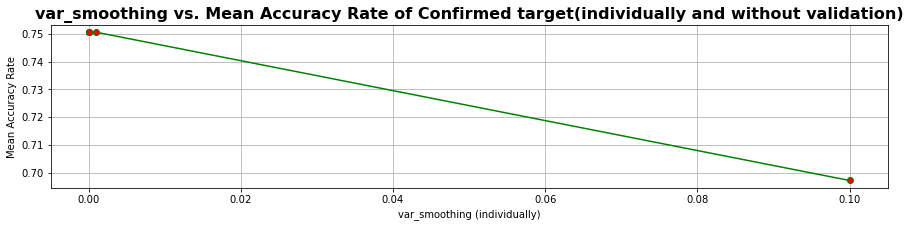

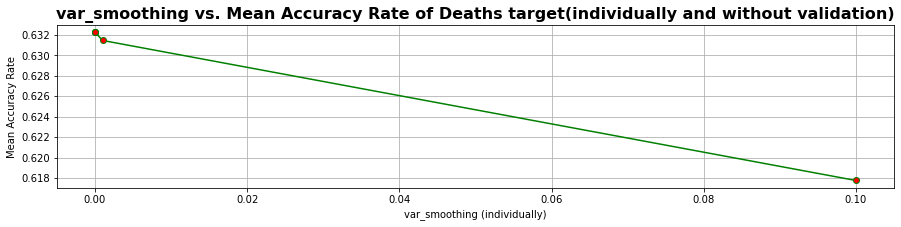

In [73]:
nbc_Confirmed_Without_Validation_SMOTE=gaussianNB_Without_Validation(x_Confirmed,y_sm_Confirmed,'individually',None,'Confirmed')
nbc_Deaths_Without_Validation_SMOTE=gaussianNB_Without_Validation(x_Deaths,y_sm_Deaths,'individually',None,'Deaths')